## What if we trained OSCD nets on crop rotation dataset?

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as tr
from torchinfo import summary

# Other
import os
import numpy as np
import random
from skimage import io
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm as tqdm
from pandas import read_csv
from math import floor, ceil, sqrt, exp
from IPython import display
import time
from itertools import chain
import time
import warnings
from pprint import pprint

from numpy.random import RandomState
from sklearn.model_selection import KFold

SEED=2342

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
print('IMPORTS OK')

# Global Variables' Definitions

PATH_TO_DATASET = './crop_rotation/'
IS_PROTOTYPE = False

FP_MODIFIER = 10 # Tuning parameter, use 1 if unsure
#BATCH_SIZE = 32
BATCH_SIZE = 8
#BATCH_SIZE = 1

PATCH_SIDE = 128
PATCH_SIDE = 64

N_EPOCHS = 10
NORMALISE_IMGS = True
TRAIN_STRIDE = int(PATCH_SIDE/2) - 1
TYPE = 3 # 0-RGB | 1-RGBIr | 2-All bands s.t. resulution <= 20m | 3-All bands
LOAD_TRAINED = False
DATA_AUG = True
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device = torch.device("cpu") 

print('DEFINITIONS OK')

# Dataset Functions

def adjust_shape(I, s):
    """Adjust shape of grayscale image I to s."""
    
    # crop if necesary
    I = I[:s[0],:s[1]]
    si = I.shape
    
    # pad if necessary 
    p0 = max(0,s[0] - si[0])
    p1 = max(0,s[1] - si[1])
    
    return np.pad(I,((0,p0),(0,p1)),'edge')
    

def read_sentinel_img(path):
    """Read cropped Sentinel-2 image: RGB bands."""
    im_name = os.listdir(path)[0][:-7]
    r = io.imread(path + im_name + "B04.tif")
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    
    I = np.stack((r,g,b),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_4(path):
    """Read cropped Sentinel-2 image: RGB and NIR bands."""
    im_name = os.listdir(path)[0][:-7]
    r = io.imread(path + im_name + "B04.tif")
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")
    
    I = np.stack((r,g,b,nir),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_leq20(path):
    """Read cropped Sentinel-2 image: bands with resolution less than or equals to 20m."""
    im_name = os.listdir(path)[0][:-7]
    
    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")
    
    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)
    
    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_leq60(path):
    """Read cropped Sentinel-2 image: all bands."""
    im_name = os.listdir(path)[0][:-7]
    
    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")
    
    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)
    
    uv = adjust_shape(zoom(io.imread(path + im_name + "B01.tif"),6),s)
    wv = adjust_shape(zoom(io.imread(path + im_name + "B09.tif"),6),s)
    swirc = adjust_shape(zoom(io.imread(path + im_name + "B10.tif"),6),s)
    
    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3,uv,wv,swirc),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_trio(path):
    """Read cropped Sentinel-2 image pair and change map."""
#     read images
    if TYPE == 0:
        I1 = read_sentinel_img(path + '/imgs_1/')
        I2 = read_sentinel_img(path + '/imgs_2/')
    elif TYPE == 1:
        I1 = read_sentinel_img_4(path + '/imgs_1/')
        I2 = read_sentinel_img_4(path + '/imgs_2/')
    elif TYPE == 2:
        I1 = read_sentinel_img_leq20(path + '/imgs_1/')
        I2 = read_sentinel_img_leq20(path + '/imgs_2/')
    elif TYPE == 3:
        I1 = read_sentinel_img_leq60(path + '/imgs_1/')
        I2 = read_sentinel_img_leq60(path + '/imgs_2/')
        
    cm = io.imread(path + '/cm/cm.png', as_gray=True) != 0
    
    # crop if necessary
    s1 = I1.shape
    s2 = I2.shape
    I2 = np.pad(I2,((0, s1[0] - s2[0]), (0, s1[1] - s2[1]), (0,0)),'edge')
    
    
    return I1, I2, cm



def reshape_for_torch(I):
    """Transpose image for PyTorch coordinates."""
#     out = np.swapaxes(I,1,2)
#     out = np.swapaxes(out,0,1)
#     out = out[np.newaxis,:]
    out = I.transpose((2, 0, 1))
    return torch.from_numpy(out)



class ChangeDetectionDataset(Dataset):
    """Change Detection dataset class, used for both training and test data."""

    def __init__(self, path, train = True, patch_side = 128, stride = None, use_all_bands = False, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        # basics
        self.transform = transform
        self.path = path
        self.patch_side = patch_side
        if not stride:
            self.stride = 1
        else:
            self.stride = stride
        
        if train:
            fname = 'all.txt'
        else:
            fname = 'test.txt'
        
#         print(path + fname)
        self.names = read_csv(path + fname).columns
        self.n_imgs = self.names.shape[0]
        
        n_pix = 0
        true_pix = 0
        
        
        # load images
        self.imgs_1 = {}
        self.imgs_2 = {}
        self.change_maps = {}
        self.n_patches_per_image = {}
        self.n_patches = 0
        self.patch_coords = []
        for im_name in tqdm(self.names):
            # load and store each image
            I1, I2, cm = read_sentinel_img_trio(self.path + im_name)
            self.imgs_1[im_name] = reshape_for_torch(I1)
            self.imgs_2[im_name] = reshape_for_torch(I2)
            self.change_maps[im_name] = cm
            
            s = cm.shape
            n_pix += np.prod(s)
            true_pix += cm.sum()
            
            # calculate the number of patches
            s = self.imgs_1[im_name].shape
            n1 = ceil((s[1] - self.patch_side + 1) / self.stride)
            n2 = ceil((s[2] - self.patch_side + 1) / self.stride)
            n_patches_i = n1 * n2
            self.n_patches_per_image[im_name] = n_patches_i
            self.n_patches += n_patches_i
            
            # generate path coordinates
            for i in range(n1):
                for j in range(n2):
                    # coordinates in (x1, x2, y1, y2)
                    current_patch_coords = (im_name, 
                                    [self.stride*i, self.stride*i + self.patch_side, self.stride*j, self.stride*j + self.patch_side],
                                    [self.stride*(i + 1), self.stride*(j + 1)])
                    self.patch_coords.append(current_patch_coords)
                    
        self.weights = [ FP_MODIFIER * 2 * true_pix / n_pix, 2 * (n_pix - true_pix) / n_pix]
        
    def get_img(self, im_name):
        return self.imgs_1[im_name], self.imgs_2[im_name], self.change_maps[im_name]        

    def get_ood_img(self, im_name):
        return self.transform(self.imgs_1[im_name]).squeeze(0), self.transform(self.imgs_2[im_name]).squeeze(0), self.change_maps[im_name]
        
    def __len__(self):
        return self.n_patches

    def __getitem__(self, idx):
        current_patch_coords = self.patch_coords[idx]
        im_name = current_patch_coords[0]
        limits = current_patch_coords[1]
        centre = current_patch_coords[2]
        
        I1 = self.imgs_1[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
        I2 = self.imgs_2[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
        
        label = self.change_maps[im_name][limits[0]:limits[1], limits[2]:limits[3]]
        label = torch.from_numpy(1*np.array(label)).float()
        
        sample = {'I1': I1, 'I2': I2, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)

        return sample



class RandomFlip(object):
    """Flip randomly the images in a sample."""

#     def __init__(self):
#         return

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']
        
        if random.random() > 0.5:
            I1 =  I1.numpy()[:,:,::-1].copy()
            I1 = torch.from_numpy(I1)
            I2 =  I2.numpy()[:,:,::-1].copy()
            I2 = torch.from_numpy(I2)
            label =  label.numpy()[:,::-1].copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}



class RandomRot(object):
    """Rotate randomly the images in a sample."""

#     def __init__(self):
#         return

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']
        
        n = random.randint(0, 3)
        if n:
            I1 =  sample['I1'].numpy()
            I1 = np.rot90(I1, n, axes=(1, 2)).copy()
            I1 = torch.from_numpy(I1)
            I2 =  sample['I2'].numpy()
            I2 = np.rot90(I2, n, axes=(1, 2)).copy()
            I2 = torch.from_numpy(I2)
            label =  sample['label'].numpy()
            label = np.rot90(label, n, axes=(0, 1)).copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}

print('UTILS OK')

# Training functions
def train(model, net_name, criterion, optimizer, scheduler, train_loader, train_dataset, test_dataset, feat=False, n_epochs = N_EPOCHS, save = True):
    L = 1024
    N = 2
    t = np.linspace(1, n_epochs, n_epochs)
    
    epoch_train_loss = 0 * t
    epoch_train_accuracy = 0 * t
    epoch_train_change_accuracy = 0 * t
    epoch_train_nochange_accuracy = 0 * t
    epoch_train_precision = 0 * t
    epoch_train_recall = 0 * t
    epoch_train_Fmeasure = 0 * t
    epoch_test_loss = 0 * t
    epoch_test_accuracy = 0 * t
    epoch_test_change_accuracy = 0 * t
    epoch_test_nochange_accuracy = 0 * t
    epoch_test_precision = 0 * t
    epoch_test_recall = 0 * t
    epoch_test_Fmeasure = 0 * t
    
    
    fm = 0
    best_fm = 0
    
    lss = 1000
    best_lss = 1000
    
    plt.figure(num=1)
    plt.figure(num=2)
    plt.figure(num=3)
    
    for epoch_index in tqdm(range(n_epochs)):
        model.train()
        print('Epoch: ' + str(epoch_index + 1) + ' of ' + str(N_EPOCHS))

        tot_count = 0
        tot_loss = 0
        tot_accurate = 0
        class_correct = list(0. for i in range(2))
        class_total = list(0. for i in range(2))
#         for batch_index, batch in enumerate(tqdm(data_loader)):
        for batch in train_loader:
            I1 = Variable(batch['I1'].float().to(device))
            #I1 = Variable(batch['I1'].float())
            #I2 = Variable(batch['I2'].float())
            I2 = Variable(batch['I2'].float().to(device))
            #I2 = Variable(batch['I2'].float())
            #label = torch.squeeze(Variable(batch['label'].cuda()))
            label = torch.squeeze(Variable(batch['label'].to(device)))

            optimizer.zero_grad()
            if feat:
                output, _ = model(I1, I2)
            else:
                output = model(I1, I2)
            loss = criterion(output, label.long())
            loss.backward()
            optimizer.step()
            
        scheduler.step()


        epoch_train_loss[epoch_index], epoch_train_accuracy[epoch_index], cl_acc, pr_rec = test(train_dataset, criterion, model, feat=feat)
        epoch_train_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_train_change_accuracy[epoch_index] = cl_acc[1]
        epoch_train_precision[epoch_index] = pr_rec[0]
        epoch_train_recall[epoch_index] = pr_rec[1]
        epoch_train_Fmeasure[epoch_index] = pr_rec[2]
        
        epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_dataset, criterion, model, feat=feat)
        epoch_test_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_test_change_accuracy[epoch_index] = cl_acc[1]
        epoch_test_precision[epoch_index] = pr_rec[0]
        epoch_test_recall[epoch_index] = pr_rec[1]
        epoch_test_Fmeasure[epoch_index] = pr_rec[2]

        plt.figure(num=1)
        plt.clf()
        l1_1, = plt.plot(t[:epoch_index + 1], epoch_train_loss[:epoch_index + 1], label='Train loss')
        l1_2, = plt.plot(t[:epoch_index + 1], epoch_test_loss[:epoch_index + 1], label='Test loss')
        plt.legend(handles=[l1_1, l1_2])
        plt.grid()
#         plt.gcf().gca().set_ylim(bottom = 0)
        plt.gcf().gca().set_xlim(left = 0)
        plt.title('Loss')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=2)
        plt.clf()
        l2_1, = plt.plot(t[:epoch_index + 1], epoch_train_accuracy[:epoch_index + 1], label='Train accuracy')
        l2_2, = plt.plot(t[:epoch_index + 1], epoch_test_accuracy[:epoch_index + 1], label='Test accuracy')
        plt.legend(handles=[l2_1, l2_2])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=3)
        plt.clf()
        l3_1, = plt.plot(t[:epoch_index + 1], epoch_train_nochange_accuracy[:epoch_index + 1], label='Train accuracy: no change')
        l3_2, = plt.plot(t[:epoch_index + 1], epoch_train_change_accuracy[:epoch_index + 1], label='Train accuracy: change')
        l3_3, = plt.plot(t[:epoch_index + 1], epoch_test_nochange_accuracy[:epoch_index + 1], label='Test accuracy: no change')
        l3_4, = plt.plot(t[:epoch_index + 1], epoch_test_change_accuracy[:epoch_index + 1], label='Test accuracy: change')
        plt.legend(handles=[l3_1, l3_2, l3_3, l3_4])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy per class')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=4)
        plt.clf()
        l4_1, = plt.plot(t[:epoch_index + 1], epoch_train_precision[:epoch_index + 1], linewidth = '1', label='Train precision')
        l4_2, = plt.plot(t[:epoch_index + 1], epoch_train_recall[:epoch_index + 1],  linewidth = '1', label='Train recall')
        l4_3, = plt.plot(t[:epoch_index + 1], epoch_train_Fmeasure[:epoch_index + 1],  linewidth = '1', label='Train Dice/F1')
        l4_4, = plt.plot(t[:epoch_index + 1], epoch_test_precision[:epoch_index + 1],  linestyle='dashed', linewidth = '2', label='Test precision')
        l4_5, = plt.plot(t[:epoch_index + 1], epoch_test_recall[:epoch_index + 1], linestyle='dashed', linewidth = '2', label='Test recall')
        l4_6, = plt.plot(t[:epoch_index + 1], epoch_test_Fmeasure[:epoch_index + 1], linestyle='dashed', linewidth = '2', label='Test Dice/F1')
        plt.legend(handles=[l4_1, l4_2, l4_3, l4_4, l4_5, l4_6])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 1)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Precision, Recall and F-measure')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        
        
        
#         fm = pr_rec[2]
        fm = epoch_train_Fmeasure[epoch_index]
        if fm > best_fm:
            best_fm = fm
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_fm-' + str(fm) + '.pth.tar'
            torch.save(model.state_dict(), save_str)
        
        lss = epoch_train_loss[epoch_index]
        if lss < best_lss:
            best_lss = lss
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_loss-' + str(lss) + '.pth.tar'
            torch.save(model.state_dict(), save_str)
            
            
#         print('Epoch loss: ' + str(tot_loss/tot_count))
        if save:
            im_format = 'png'
    #         im_format = 'eps'

            plt.figure(num=1)
            plt.savefig(net_name + '-01-loss.' + im_format)

            plt.figure(num=2)
            plt.savefig(net_name + '-02-accuracy.' + im_format)

            plt.figure(num=3)
            plt.savefig(net_name + '-03-accuracy-per-class.' + im_format)

            plt.figure(num=4)
            plt.savefig(net_name + '-04-prec-rec-fmeas.' + im_format)
        
    out = {'train_loss': epoch_train_loss[-1],
           'train_accuracy': epoch_train_accuracy[-1],
           'train_nochange_accuracy': epoch_train_nochange_accuracy[-1],
           'train_change_accuracy': epoch_train_change_accuracy[-1],
           'test_loss': epoch_test_loss[-1],
           'test_accuracy': epoch_test_accuracy[-1],
           'test_nochange_accuracy': epoch_test_nochange_accuracy[-1],
           'test_change_accuracy': epoch_test_change_accuracy[-1]}
    
    print('pr_c, rec_c, f_meas, pr_nc, rec_nc')
    print(pr_rec)
    
    return out


def kappa(tp, tn, fp, fn):
    N = tp + tn + fp + fn
    p0 = (tp + tn) / N
    pe = ((tp+fp)*(tp+fn) + (tn+fp)*(tn+fn)) / (N * N)
    
    return (p0 - pe) / (1 - pe)

def test_patch_batch(dset, criterion, model, feat=False, batch_size=BATCH_SIZE, patch_size=PATCH_SIDE):
    L = 1024
    N = 2
    model.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    model = model.to(device)
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in dset.names:
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        full_x, full_y = cm_full.shape
        cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm_full),0).float().to(device))
        cm_patch, cm_x, cm_y, cm_px, cm_py = get_mask_patch_batch(cm_full)
        I1_patch, i_x, i_y, i_px, i_py = get_image_patch_batch(I1_full)
        I2_patch, _, _, _, _ = get_image_patch_batch(I2_full)
        
        # first perform inference
        I1 = Variable(I1_patch.float().to(device))
        I2 = Variable(I2_patch.float().to(device))
        if feat:
            output, _ = model(I1, I2)
        else:
            output = model(I1, I2)
        #print(output.shape)
        output_size = (cm_px,cm_py)
        b_s =  1
        cm_recon = reconstruct_image_batch(output, b_s, output_size, patch_size)
        #print(cm_recon.shape)
        output = cm_recon[:, :, :full_x, :full_y]
        #print(output.shape)
        loss = criterion(output, cm.long())
        tot_loss += loss.data * np.prod(cm.size())
        tot_count += np.prod(cm.size())

        _, predicted = torch.max(output.data, 1)

        c = (predicted.int() == cm.data.int())
        for i in range(c.size(1)):
            for j in range(c.size(2)):
                l = int(cm.data[0, i, j])
                class_correct[l] += c[0, i, j]
                class_total[l] += 1
                
        pr = (predicted.int() > 0).cpu().numpy()
        gt = (cm.data.int() > 0).cpu().numpy()
        
        tp += np.logical_and(pr, gt).sum()
        tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
        fp += np.logical_and(pr, np.logical_not(gt)).sum()
        fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count        
    net_loss = float(net_loss.cpu().numpy())
    
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
        class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)


    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, f_meas, prec_nc, rec_nc]
        
    return net_loss, net_accuracy, class_accuracy, pr_rec



def train_batch(model, net_name, criterion, optimizer, scheduler, train_loader, train_dataset, test_dataset, feat=False, n_epochs = N_EPOCHS, save = True):
    L = 1024
    N = 2
    t = np.linspace(1, n_epochs, n_epochs)
    
    epoch_train_loss = 0 * t
    epoch_train_accuracy = 0 * t
    epoch_train_change_accuracy = 0 * t
    epoch_train_nochange_accuracy = 0 * t
    epoch_train_precision = 0 * t
    epoch_train_recall = 0 * t
    epoch_train_Fmeasure = 0 * t
    epoch_test_loss = 0 * t
    epoch_test_accuracy = 0 * t
    epoch_test_change_accuracy = 0 * t
    epoch_test_nochange_accuracy = 0 * t
    epoch_test_precision = 0 * t
    epoch_test_recall = 0 * t
    epoch_test_Fmeasure = 0 * t
    
    
#     mean_acc = 0
#     best_mean_acc = 0
    fm = 0
    best_fm = 0
    
    lss = 1000
    best_lss = 1000
    
    plt.figure(num=1)
    plt.figure(num=2)
    plt.figure(num=3)
    
    for epoch_index in tqdm(range(n_epochs)):
        model.train()
        print('Epoch: ' + str(epoch_index + 1) + ' of ' + str(N_EPOCHS))

        tot_count = 0
        tot_loss = 0
        tot_accurate = 0
        class_correct = list(0. for i in range(2))
        class_total = list(0. for i in range(2))
#         for batch_index, batch in enumerate(tqdm(data_loader)):
        for batch in train_loader:
            I1 = Variable(batch['I1'].float().to(device))
            #I1 = Variable(batch['I1'].float())
            #I2 = Variable(batch['I2'].float())
            I2 = Variable(batch['I2'].float().to(device))
            #I2 = Variable(batch['I2'].float())
            #label = torch.squeeze(Variable(batch['label'].cuda()))
            label = torch.squeeze(Variable(batch['label'].to(device)))

            optimizer.zero_grad()
            if feat:
                output, _ = model(I1, I2)
            else:
                output = model(I1, I2)
            loss = criterion(output, label.long())
            loss.backward()
            optimizer.step()
            
        scheduler.step()


        epoch_train_loss[epoch_index], epoch_train_accuracy[epoch_index], cl_acc, pr_rec = test_patch_batch(train_dataset, criterion, model, feat=True)
        epoch_train_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_train_change_accuracy[epoch_index] = cl_acc[1]
        epoch_train_precision[epoch_index] = pr_rec[0]
        epoch_train_recall[epoch_index] = pr_rec[1]
        epoch_train_Fmeasure[epoch_index] = pr_rec[2]
        
        epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test_patch_batch(test_dataset, criterion, model, feat=True)
        epoch_test_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_test_change_accuracy[epoch_index] = cl_acc[1]
        epoch_test_precision[epoch_index] = pr_rec[0]
        epoch_test_recall[epoch_index] = pr_rec[1]
        epoch_test_Fmeasure[epoch_index] = pr_rec[2]

        plt.figure(num=1)
        plt.clf()
        l1_1, = plt.plot(t[:epoch_index + 1], epoch_train_loss[:epoch_index + 1], label='Train loss')
        l1_2, = plt.plot(t[:epoch_index + 1], epoch_test_loss[:epoch_index + 1], label='Test loss')
        plt.legend(handles=[l1_1, l1_2])
        plt.grid()
#         plt.gcf().gca().set_ylim(bottom = 0)
        plt.gcf().gca().set_xlim(left = 0)
        plt.title('Loss')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=2)
        plt.clf()
        l2_1, = plt.plot(t[:epoch_index + 1], epoch_train_accuracy[:epoch_index + 1], label='Train accuracy')
        l2_2, = plt.plot(t[:epoch_index + 1], epoch_test_accuracy[:epoch_index + 1], label='Test accuracy')
        plt.legend(handles=[l2_1, l2_2])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=3)
        plt.clf()
        l3_1, = plt.plot(t[:epoch_index + 1], epoch_train_nochange_accuracy[:epoch_index + 1], label='Train accuracy: no change')
        l3_2, = plt.plot(t[:epoch_index + 1], epoch_train_change_accuracy[:epoch_index + 1], label='Train accuracy: change')
        l3_3, = plt.plot(t[:epoch_index + 1], epoch_test_nochange_accuracy[:epoch_index + 1], label='Test accuracy: no change')
        l3_4, = plt.plot(t[:epoch_index + 1], epoch_test_change_accuracy[:epoch_index + 1], label='Test accuracy: change')
        plt.legend(handles=[l3_1, l3_2, l3_3, l3_4])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy per class')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=4)
        plt.clf()
        l4_1, = plt.plot(t[:epoch_index + 1], epoch_train_precision[:epoch_index + 1], linewidth = '1', label='Train precision')
        l4_2, = plt.plot(t[:epoch_index + 1], epoch_train_recall[:epoch_index + 1],  linewidth = '1', label='Train recall')
        l4_3, = plt.plot(t[:epoch_index + 1], epoch_train_Fmeasure[:epoch_index + 1],  linewidth = '1', label='Train Dice/F1')
        l4_4, = plt.plot(t[:epoch_index + 1], epoch_test_precision[:epoch_index + 1],  linestyle='dashed', linewidth = '2', label='Test precision')
        l4_5, = plt.plot(t[:epoch_index + 1], epoch_test_recall[:epoch_index + 1], linestyle='dashed', linewidth = '2', label='Test recall')
        l4_6, = plt.plot(t[:epoch_index + 1], epoch_test_Fmeasure[:epoch_index + 1], linestyle='dashed', linewidth = '2', label='Test Dice/F1')
        plt.legend(handles=[l4_1, l4_2, l4_3, l4_4, l4_5, l4_6])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 1)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Precision, Recall and F-measure')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        
        
        
#         fm = pr_rec[2]
        fm = epoch_train_Fmeasure[epoch_index]
        if fm > best_fm:
            best_fm = fm
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_fm-' + str(fm) + '.pth.tar'
            torch.save(model.state_dict(), save_str)
        
        lss = epoch_train_loss[epoch_index]
        if lss < best_lss:
            best_lss = lss
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_loss-' + str(lss) + '.pth.tar'
            torch.save(model.state_dict(), save_str)
            
            
#         print('Epoch loss: ' + str(tot_loss/tot_count))
        if save:
            im_format = 'png'
    #         im_format = 'eps'

            plt.figure(num=1)
            plt.savefig(net_name + '-01-loss.' + im_format)

            plt.figure(num=2)
            plt.savefig(net_name + '-02-accuracy.' + im_format)

            plt.figure(num=3)
            plt.savefig(net_name + '-03-accuracy-per-class.' + im_format)

            plt.figure(num=4)
            plt.savefig(net_name + '-04-prec-rec-fmeas.' + im_format)
        
    out = {'train_loss': epoch_train_loss[-1],
           'train_accuracy': epoch_train_accuracy[-1],
           'train_nochange_accuracy': epoch_train_nochange_accuracy[-1],
           'train_change_accuracy': epoch_train_change_accuracy[-1],
           'test_loss': epoch_test_loss[-1],
           'test_accuracy': epoch_test_accuracy[-1],
           'test_nochange_accuracy': epoch_test_nochange_accuracy[-1],
           'test_change_accuracy': epoch_test_change_accuracy[-1]}
    
    print('pr_c, rec_c, f_meas, pr_nc, rec_nc')
    print(pr_rec)
    
    return out


def test(dset, criterion, model, feat=False):
    L = 1024
    N = 2
    model.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in dset.names:
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        
        s = cm_full.shape
        

        steps0 = np.arange(0,s[0],ceil(s[0]/N))
        steps1 = np.arange(0,s[1],ceil(s[1]/N))
        for ii in range(N):
            for jj in range(N):
                xmin = steps0[ii]
                if ii == N-1:
                    xmax = s[0]
                else:
                    xmax = steps0[ii+1]
                ymin = jj
                if jj == N-1:
                    ymax = s[1]
                else:
                    ymax = steps1[jj+1]
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                I1 = Variable(torch.unsqueeze(I1, 0).float().to(device))
                I2 = Variable(torch.unsqueeze(I2, 0).float().to(device))
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float().to(device))
                #cm = Variable(torch.from_numpy(1.0*cm).float())
                #print(I1.shape, I2.shape, cm.shape)


                if feat:
                    output, _ = model(I1, I2)
                else:
                    output = model(I1, I2)
                loss = criterion(output, cm.long())
        #         print(loss)
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1
                        
                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()
                
                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, f_meas, prec_nc, rec_nc]
        
    return net_loss, net_accuracy, class_accuracy, pr_rec

def unseen_test(dset, criterion, model, feat=False):
    L = 1024
    N = 2
    model.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in tqdm(dset.names):
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        
        s = cm_full.shape
        
        for ii in range(ceil(s[0]/L)):
            for jj in range(ceil(s[1]/L)):
                xmin = L*ii
                xmax = min(L*(ii+1),s[1])
                ymin = L*jj
                ymax = min(L*(jj+1),s[1])
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                I1 = Variable(torch.unsqueeze(I1, 0).float())
                I2 = Variable(torch.unsqueeze(I2, 0).float())
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float())

                if feat:
                    output, _ = model(I1, I2)
                else:
                    output = model(I1, I2)
                    
                loss = criterion(output, cm.long())
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1
                        
                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()
                
                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count        
    net_loss = float(net_loss.cpu().numpy())
    
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
        class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)


    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, dice, prec_nc, rec_nc]
    
    k = kappa(tp, tn, fp, fn)
    
    return {'net_loss': net_loss, 
            'net_accuracy': net_accuracy, 
            'class_accuracy': class_accuracy, 
            'precision': prec, 
            'recall': rec, 
            'dice': dice, 
            'kappa': k,
            'f_meas':f_meas}
# test patch
def extract_patches_batch(images, patch_size):
    """
    Extracts patches from a batch of images.
    
    Args:
        images (torch.Tensor): Input images of shape (B, C, H, W).
        patch_size (int): Size of each patch.

    Returns:
        torch.Tensor: Extracted patches of shape (B * num_patches, C, patch_size, patch_size)
    """
    B, C, H, W = images.shape
    #print(images.shape)

    # Ensure the image size is divisible by patch size
    assert H % patch_size == 0 and W % patch_size == 0, "Image size must be divisible by patch size"

    # Unfold the images to extract patches
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    # Shape after unfold: (B, C, num_patches_H, num_patches_W, patch_size, patch_size)

    # Reshape into (B * num_patches, C, patch_size, patch_size)
    num_patches_H = H // patch_size
    num_patches_W = W // patch_size
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()  # (B, num_patches_H, num_patches_W, C, patch_size, patch_size)
    patches = patches.view(B * num_patches_H * num_patches_W, C, patch_size, patch_size)

    #print(f"Extracted patches shape: {patches.shape} (Expected {B * num_patches_H * num_patches_W})")
    return patches


def reconstruct_image_batch(patches, batch_size, output_size=(32, 32), patch_size=2):
    if isinstance(output_size, int):
        output_size = (output_size, output_size)  # Ensure it's a tuple

    if isinstance(batch_size, tuple):
        batch_size = batch_size[0]  # Extract integer batch size

    # Ensure output size is valid
    if output_size[0] < patch_size or output_size[1] < patch_size:
        raise ValueError(f"Output size {output_size} must be larger than patch size {patch_size}")

    num_patches_per_row = output_size[0] // patch_size
    num_patches_per_col = output_size[1] // patch_size
    num_patches = num_patches_per_row * num_patches_per_col

    #print(f"Num patches: {num_patches}")
    #print(f"Fixed batch_size: {batch_size}")
    #print(f"num_patches_per_row: {num_patches_per_row}, num_patches_per_col: {num_patches_per_col}")
    #print(f"Expected {batch_size * num_patches} patches, but got {patches.shape[0]}")

    # Fix batch_size issue
    if patches.shape[0] == batch_size * num_patches:
        patches = patches.view(batch_size, num_patches_per_row, num_patches_per_col, -1, patch_size, patch_size)
    elif patches.shape[0] == num_patches:
        # If only patches for one image exist, assume batch_size=1
        patches = patches.view(1, num_patches_per_row, num_patches_per_col, -1, patch_size, patch_size)
    else:
        raise ValueError(f"Unexpected number of patches: {patches.shape[0]}")

    patches = patches.permute(0, 3, 1, 4, 2, 5).contiguous()
    reconstructed = patches.view(batch_size, -1, output_size[0], output_size[1])

    return reconstructed

def pad_trick(i, p):
    """
    Pads a multi-channel image to be divisible by p.
    
    Args:
        i (torch.Tensor or np.ndarray): Input image tensor of shape (C, H, W).
        p (int): Patch size to pad to.
    
    Returns:
        torch.Tensor: Padded image tensor of shape (C, H+p_h, W+p_w).
    """
    if isinstance(i, np.ndarray):
        i = torch.from_numpy(i)

    assert i.ndim == 3, f"Expected input shape (C, H, W), but got {i.shape}"

    C, H, W = i.shape  # Now considering channels
    p_h = (p - (H % p)) % p
    p_w = (p - (W % p)) % p

    # Padding format: (left, right, top, bottom)
    pi = F.pad(i, (0, p_w, 0, p_h), mode="constant", value=0)
    return pi


def get_mask_patch_batch(cmt):
    b_s = 1
    patch_size = PATCH_SIDE
    cmt = torch.from_numpy(cmt)
    orig_x = cmt.shape[0]
    orig_y = cmt.shape[1]
    cmt = torch.unsqueeze(cmt, 0)
    cmt = pad_trick(cmt, patch_size)
    cm_batch = torch.unsqueeze(cmt, 0)
    cm_patch = extract_patches_batch(cm_batch, patch_size)
    padded_x = cm_batch.shape[2]
    padded_y = cm_batch.shape[3]
    #cm_recon = reconstruct_image_batch(cm_patch, b_s, output_size, patch_size)
    return cm_patch, orig_x, orig_y, padded_x, padded_y 

def get_image_patch_batch(cmt):
    b_s = 1
    patch_size = PATCH_SIDE
    #cmt = torch.from_numpy(cmt)
    orig_x = cmt.shape[1]
    orig_y = cmt.shape[2]
    cmt = pad_trick(cmt, patch_size)
    cm_batch = torch.unsqueeze(cmt, 0)
    padded_x = cm_batch.shape[2]
    padded_y = cm_batch.shape[3]
    cm_patch = extract_patches_batch(cm_batch, patch_size)
    #cm_recon = reconstruct_image_batch(cm_patch, b_s, output_size, patch_size)
    return cm_patch, orig_x, orig_y, padded_x, padded_y
    
def unseen_test_patch(dset, criterion, model, feat=False):
    L = 1024
    N = 2
    model.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    model = model.to(device)
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in tqdm(dset.names):
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        cm_patch, cm_x, cm_y, cm_px, cm_py = get_mask_patch_batch(cm_full)
        I1_patch, i_x, i_y, i_px, i_py = get_image_patch_batch(I1_full)
        I2_patch, _, _, _, _ = get_image_patch_batch(I2_full)
        #print(I1_patch.shape)

        for i in range(cm_patch.shape[0]):
            I1 = I1_patch[i]
            I2 = I2_patch[i]
            cm = cm_patch[i]
            #print(I1.shape)

            I1 = Variable(torch.unsqueeze(I1, 0).float().to(device))
            I2 = Variable(torch.unsqueeze(I2, 0).float().to(device))
            cm = Variable((1.0*cm).float().to(device))

            if feat:
                output, _ = model(I1, I2)
            else:
                output = model(I1, I2)
                
            loss = criterion(output, cm.long())
            tot_loss += loss.data * np.prod(cm.size())
            tot_count += np.prod(cm.size())

            _, predicted = torch.max(output.data, 1)

            c = (predicted.int() == cm.data.int())
            for i in range(c.size(1)):
                for j in range(c.size(2)):
                    l = int(cm.data[0, i, j])
                    class_correct[l] += c[0, i, j]
                    class_total[l] += 1
                    
            pr = (predicted.int() > 0).cpu().numpy()
            gt = (cm.data.int() > 0).cpu().numpy()
            
            tp += np.logical_and(pr, gt).sum()
            tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
            fp += np.logical_and(pr, np.logical_not(gt)).sum()
            fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count        
    net_loss = float(net_loss.cpu().numpy())
    
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
        class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)


    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, dice, prec_nc, rec_nc]
    
    k = kappa(tp, tn, fp, fn)
    
    return {'net_loss': net_loss, 
            'net_accuracy': net_accuracy, 
            'class_accuracy': class_accuracy, 
            'precision': prec, 
            'recall': rec, 
            'dice': dice, 
            'kappa': k,
            'f_meas':f_meas}

def unseen_test_patch_batch(dset, criterion, model, feat=False, batch_size=BATCH_SIZE, patch_size=PATCH_SIDE, ood=False):
    L = 1024
    N = 2
    model.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    model = model.to(device)
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in tqdm(dset.names):
        if ood:
            I1_full, I2_full, cm_full = dset.get_ood_img(img_index)
        else:
            I1_full, I2_full, cm_full = dset.get_img(img_index)
        full_x, full_y = cm_full.shape
        cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm_full),0).float().to(device))
        cm_patch, cm_x, cm_y, cm_px, cm_py = get_mask_patch_batch(cm_full)
        I1_patch, i_x, i_y, i_px, i_py = get_image_patch_batch(I1_full)
        I2_patch, _, _, _, _ = get_image_patch_batch(I2_full)
        
        # first perform inference
        I1 = Variable(I1_patch.float().to(device))
        I2 = Variable(I2_patch.float().to(device))
        if feat:
            output, _ = model(I1, I2)
        else:
            output = model(I1, I2)
        #print(output.shape)
        output_size = (cm_px,cm_py)
        b_s =  1
        cm_recon = reconstruct_image_batch(output, b_s, output_size, patch_size)
        #print(cm_recon.shape)
        output = cm_recon[:, :, :full_x, :full_y]
        #print(output.shape)
        loss = criterion(output, cm.long())
        tot_loss += loss.data * np.prod(cm.size())
        tot_count += np.prod(cm.size())

        _, predicted = torch.max(output.data, 1)

        c = (predicted.int() == cm.data.int())
        for i in range(c.size(1)):
            for j in range(c.size(2)):
                l = int(cm.data[0, i, j])
                class_correct[l] += c[0, i, j]
                class_total[l] += 1
                
        pr = (predicted.int() > 0).cpu().numpy()
        gt = (cm.data.int() > 0).cpu().numpy()
        
        tp += np.logical_and(pr, gt).sum()
        tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
        fp += np.logical_and(pr, np.logical_not(gt)).sum()
        fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count        
    net_loss = float(net_loss.cpu().numpy())
    
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
        class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)


    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, dice, prec_nc, rec_nc]
    
    k = kappa(tp, tn, fp, fn)
    
    return {'net_loss': net_loss, 
            'net_accuracy': net_accuracy, 
            'class_accuracy': class_accuracy, 
            'precision': prec, 
            'recall': rec, 
            'dice': dice, 
            'kappa': k,
            'f_meas':f_meas}


def unseen_test_patch_batch_robust(dset, criterion, model, feat=False, batch_size=BATCH_SIZE, patch_size=PATCH_SIDE):
    L = 1024
    N = 2
    model.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    model = model.to(device)
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for img_index in tqdm(dset.names):
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        full_x, full_y = cm_full.shape
        cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm_full),0).float().to(device))
        cm_patch, cm_x, cm_y, cm_px, cm_py = get_mask_patch_batch(cm_full)
        I1_patch, i_x, i_y, i_px, i_py = get_image_patch_batch(I1_full)
        I2_patch, _, _, _, _ = get_image_patch_batch(I2_full)
        
        # first perform inference
        I1 = Variable(I1_patch.float().to(device))
        I2 = Variable(I2_patch.float().to(device))
        if feat:
            output, _ = model(I1, I2)
        else:
            output = model(I1, I2)
        #print(output.shape)
        output_size = (cm_px,cm_py)
        b_s =  1
        cm_recon = reconstruct_image_batch(output, b_s, output_size, patch_size)
        #print(cm_recon.shape)
        output = cm_recon[:, :, :full_x, :full_y]
        #print(output.shape)
        loss = criterion(output, cm.long())
        tot_loss += loss.data * np.prod(cm.size())
        tot_count += np.prod(cm.size())

        _, predicted = torch.max(output.data, 1)

        c = (predicted.int() == cm.data.int())
        for i in range(c.size(1)):
            for j in range(c.size(2)):
                l = int(cm.data[0, i, j])
                class_correct[l] += c[0, i, j]
                class_total[l] += 1
                
        pr = (predicted.int() > 0).cpu().numpy()
        gt = (cm.data.int() > 0).cpu().numpy()
        
        tp += np.logical_and(pr, gt).sum()
        tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
        fp += np.logical_and(pr, np.logical_not(gt)).sum()
        fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    net_loss = tot_loss/tot_count        
    net_loss = float(net_loss.cpu().numpy())
    
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
        class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)


    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, dice, prec_nc, rec_nc]
    
    k = kappa(tp, tn, fp, fn)
    
    return {'net_loss': net_loss, 
            'net_accuracy': net_accuracy, 
            'class_accuracy': class_accuracy, 
            'precision': prec, 
            'recall': rec, 
            'dice': dice, 
            'kappa': k,
            'f_meas':f_meas}

    
def save_test_results(model, dset, net_name, feat=False, batch_size=BATCH_SIZE, patch_size=PATCH_SIDE):
    for name in tqdm(dset.names):
        #print(name)
        with warnings.catch_warnings():
            I1_full, I2_full, cm_full = dset.get_img(name)
            full_x, full_y = cm_full.shape
            cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm_full),0).float().to(device))
            cm_patch, cm_x, cm_y, cm_px, cm_py = get_mask_patch_batch(cm_full)
            I1_patch, i_x, i_y, i_px, i_py = get_image_patch_batch(I1_full)
            I2_patch, _, _, _, _ = get_image_patch_batch(I2_full)
            # first perform inference
            I1 = Variable(I1_patch.float().to(device))
            I2 = Variable(I2_patch.float().to(device))
            #output, _ = model(I1, I2)
            if feat:
                output, _ = model(I1, I2)
            else:
                output = model(I1, I2)
            output_size = (cm_px,cm_py)
            b_s =  1
            cm_recon = reconstruct_image_batch(output, b_s, output_size, patch_size)
            #print(cm_recon.shape)
            output = cm_recon[:, :, :full_x, :full_y]
            _, predicted = torch.max(output.data, 1)
            I = np.stack((np.squeeze(cm.cpu().numpy()),np.squeeze(predicted.cpu().numpy()),np.squeeze(cm.cpu().numpy())),2)
            #im = Image.fromarray((I * 255).astype(np.uint8))
            im = (I * 255).astype(np.uint8)
            io.imsave(f'{net_name}-{name}.png',im)
print("Training & testing Functions Defined")

IMPORTS OK
DEFINITIONS OK
UTILS OK
Training & testing Functions Defined


In [2]:
# Dataset
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

# Dataset
if DATA_AUG:
    data_transform = tr.Compose([RandomFlip(), RandomRot()])
else:
    data_transform = None
       
train_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = True, stride = TRAIN_STRIDE, transform=data_transform)
dataset_weights = torch.FloatTensor(train_dataset.weights).to(device)
print(dataset_weights)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, worker_init_fn=seed_worker,
    generator=g)

# Initialize KFold
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Iterate through folds and create datasets
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print("Train data:", X_train, y_train)
    print("Test data:", X_test, y_test)
    print("-" * 20)
test_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = False, stride = TRAIN_STRIDE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, worker_init_fn=seed_worker,
    generator=g)

print('Dataloaders Ready')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:56<00:00, 14.15s/it]


tensor([8.2887, 1.1711])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.19s/it]

Dataloaders Ready


## SoTA Network FresUNet

In [3]:
# Original SoTA Network definition
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1)


class BasicBlock_ss(nn.Module):

    def __init__(self, inplanes, planes = None, subsamp=1):
        super(BasicBlock_ss, self).__init__()
        if planes == None:
            planes = inplanes * subsamp
        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.subsamp = subsamp
        self.doit = planes != inplanes
        if self.doit:
            self.couple = nn.Conv2d(inplanes, planes, kernel_size=1)
            self.bnc = nn.BatchNorm2d(planes)

    def forward(self, x):
        if self.doit:
            residual = self.couple(x)
            residual = self.bnc(residual)
        else:
            residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        if self.subsamp > 1:
            out = F.max_pool2d(out, kernel_size=self.subsamp, stride=self.subsamp)
            residual = F.max_pool2d(residual, kernel_size=self.subsamp, stride=self.subsamp)

        out = self.conv2(out)
        out = self.bn2(out)
        
        out += residual
        out = self.relu(out)

        return out
    

    
class BasicBlock_us(nn.Module):

    def __init__(self, inplanes, upsamp=1):
        super(BasicBlock_us, self).__init__()
        planes = int(inplanes / upsamp) # assumes integer result, fix later
        self.conv1 = nn.ConvTranspose2d(inplanes, planes, kernel_size=3, padding=1, stride=upsamp, output_padding=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.upsamp = upsamp
        self.couple = nn.ConvTranspose2d(inplanes, planes, kernel_size=3, padding=1, stride=upsamp, output_padding=1) 
        self.bnc = nn.BatchNorm2d(planes)

    def forward(self, x):
        residual = self.couple(x)
        residual = self.bnc(residual)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        

        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.relu(out)

        return out
    
    
class FresUNet(nn.Module):
    """FresUNet segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        """Init FresUNet fields."""
        super(FresUNet, self).__init__()

        self.input_nbr = input_nbr
        
        cur_depth = input_nbr
        
        base_depth = 8

        self.dropout = nn.Dropout2d(p=0.3) 
        
        # Encoding stage 1
        self.encres1_1 = BasicBlock_ss(cur_depth, planes = base_depth)
        cur_depth = base_depth
        d1 = base_depth
        self.encres1_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2
        
        # Encoding stage 2
        self.encres2_1 = BasicBlock_ss(cur_depth)
        d2 = cur_depth
        self.encres2_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2
        
        # Encoding stage 3
        self.encres3_1 = BasicBlock_ss(cur_depth)
        d3 = cur_depth
        self.encres3_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2
        
        # Encoding stage 4
        self.encres4_1 = BasicBlock_ss(cur_depth)
        d4 = cur_depth
        self.encres4_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2
        
        # Decoding stage 4
        self.decres4_1 = BasicBlock_ss(cur_depth)
        self.decres4_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Decoding stage 3
        self.decres3_1 = BasicBlock_ss(cur_depth + d4, planes = cur_depth)
        self.decres3_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Decoding stage 2
        self.decres2_1 = BasicBlock_ss(cur_depth + d3, planes = cur_depth)
        self.decres2_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Decoding stage 1
        self.decres1_1 = BasicBlock_ss(cur_depth + d2, planes = cur_depth)
        self.decres1_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Output
        self.coupling = nn.Conv2d(cur_depth + d1, label_nbr, kernel_size=1)
        self.sm = nn.LogSoftmax(dim=1)
        
    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)
        
#         pad5 = ReplicationPad2d((0, x53.size(3) - x5d.size(3), 0, x53.size(2) - x5d.size(2)))
        
        s1_1 = x.size()
        x1 = self.encres1_1(x)
        x = self.encres1_2(x1)
        
        s2_1 = x.size()

        x = self.dropout(x)
        
        x2 = self.encres2_1(x)
        x = self.encres2_2(x2)
        
        s3_1 = x.size()
        x3 = self.encres3_1(x)
        x = self.encres3_2(x3)
        
        s4_1 = x.size()
        
        x = self.dropout(x)
        
        x4 = self.encres4_1(x)
        x = self.encres4_2(x4)
        # print("Sizes s : ", s1_1, s2_1, s3_1, s4_1 )  
        # print("Sizes x : ", x1.shape, x2.shape, x3.shape, x4.shape )
        # print(f"final enoded shape:{x.shape}") 
        
        x = self.dropout(x)
        
        
        x = self.decres4_1(x)
        x = self.decres4_2(x)
        s4_2 = x.size()

        
        
        pad4 = ReplicationPad2d((0, s4_1[3] - s4_2[3], 0, s4_1[2] - s4_2[2]))
        x = pad4(x)
        
        # x = self.decres3_1(x)
        x = self.decres3_1(torch.cat((x, x4), 1))
        x = self.decres3_2(x)
        s3_2 = x.size()
        pad3 = ReplicationPad2d((0, s3_1[3] - s3_2[3], 0, s3_1[2] - s3_2[2]))
        x = pad3(x)

        
        x = self.dropout(x)
        
        
        
        x = self.decres2_1(torch.cat((x, x3), 1))
        x = self.decres2_2(x)
        s2_2 = x.size()
        pad2 = ReplicationPad2d((0, s2_1[3] - s2_2[3], 0, s2_1[2] - s2_2[2]))
        x = pad2(x)


        
        x = self.dropout(x)
        
        
        
        x = self.decres1_1(torch.cat((x, x2), 1))
        x = self.decres1_2(x)
        s1_2 = x.size()
        pad1 = ReplicationPad2d((0, s1_1[3] - s1_2[3], 0, s1_1[2] - s1_2[2]))
        x = pad1(x)
        
        x = self.coupling(torch.cat((x, x1), 1))
        x = self.sm(x)
        
        return x
# Example usage
model, model_name = FresUNet(2*13, 2), 'FresUNet'
x = torch.randn(1, 13, 128, 128)
out = model(x, x)
print(summary(model, input_size=(x.shape, x.shape)))

Layer (type:depth-idx)                   Output Shape              Param #
FresUNet                                 [1, 2, 128, 128]          --
├─BasicBlock_ss: 1-1                     [1, 8, 128, 128]          --
│    └─Conv2d: 2-1                       [1, 8, 128, 128]          216
│    └─BatchNorm2d: 2-2                  [1, 8, 128, 128]          16
│    └─Conv2d: 2-3                       [1, 8, 128, 128]          1,880
│    └─BatchNorm2d: 2-4                  [1, 8, 128, 128]          16
│    └─ReLU: 2-5                         [1, 8, 128, 128]          --
│    └─Conv2d: 2-6                       [1, 8, 128, 128]          584
│    └─BatchNorm2d: 2-7                  [1, 8, 128, 128]          16
│    └─ReLU: 2-8                         [1, 8, 128, 128]          --
├─BasicBlock_ss: 1-2                     [1, 16, 64, 64]           --
│    └─Conv2d: 2-9                       [1, 16, 128, 128]         144
│    └─BatchNorm2d: 2-10                 [1, 16, 128, 128]         32
│    └─Co

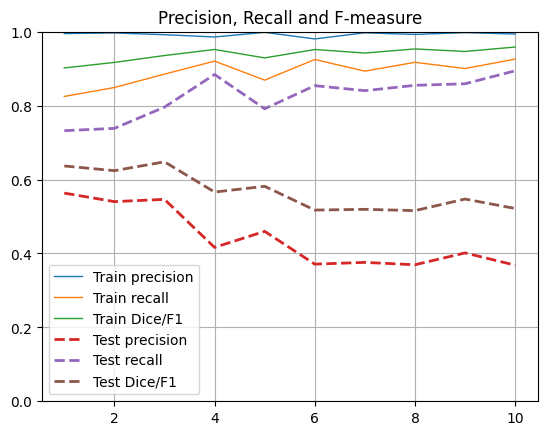

100%|██████████████████████████████████████████| 10/10 [35:22<00:00, 212.29s/it]


pr_c, rec_c, f_meas, pr_nc, rec_nc
[np.float64(0.3681688235121609), np.float64(0.8941825451794653), np.float64(0.5215824117258981), np.float64(0.9758250181099142), np.float64(0.7356907228182746)]
{'train_loss': np.float64(0.056160904467105865), 'train_accuracy': np.float64(96.61538628096311), 'train_nochange_accuracy': np.float64(99.57168579101562), 'train_change_accuracy': np.float64(92.5691909790039), 'test_loss': np.float64(0.8003724217414856), 'test_accuracy': np.float64(75.89782175645244), 'test_nochange_accuracy': np.float64(73.5690689086914), 'test_change_accuracy': np.float64(89.41825103759766)}
Elapsed time for training:
2122.93563246727
SAVE OK
LOAD OK


100%|█████████████████████████████████████████████| 2/2 [00:23<00:00, 11.62s/it]

{'class_accuracy': [72.42903900146484, 88.9278335571289],
 'dice': np.float64(0.525662860997071),
 'f_meas': np.float64(0.525662860997071),
 'kappa': np.float64(0.39228526292555327),
 'net_accuracy': np.float64(74.99918835385175),
 'net_loss': 0.8230130672454834,
 'precision': np.float64(0.3731047247078026),
 'recall': np.float64(0.8892783082603606)}
Elapsed time for testing:
23.30769920349121


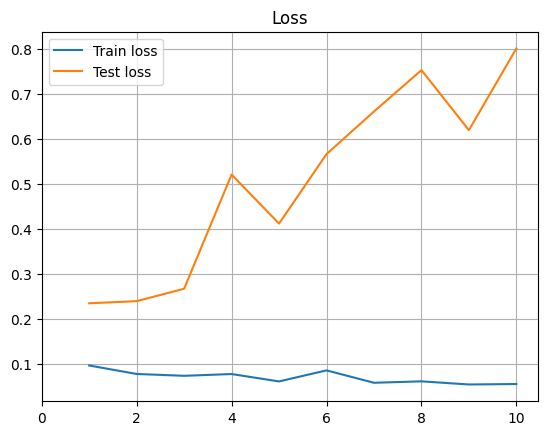

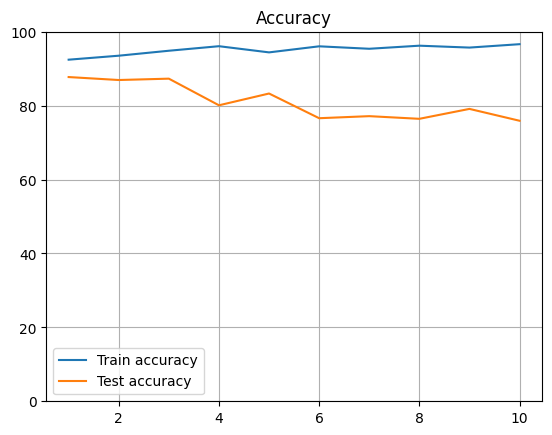

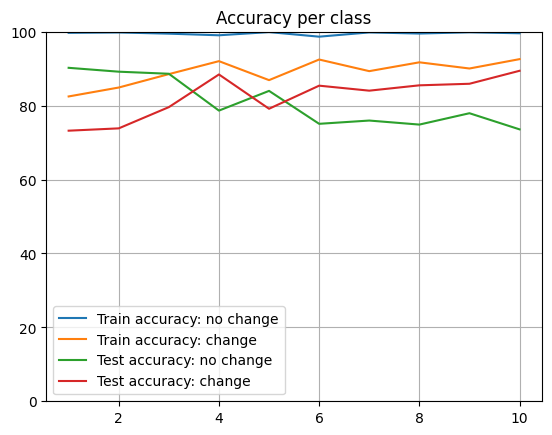

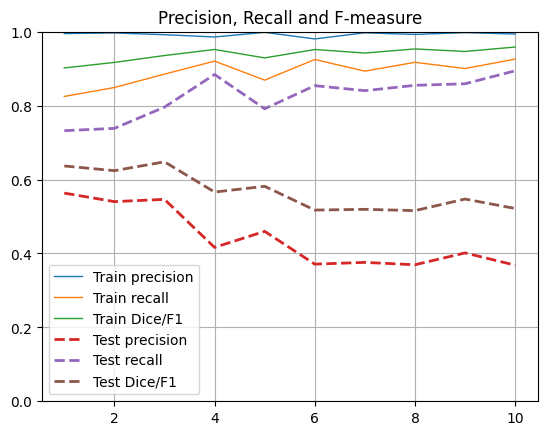

In [4]:
# Original SoTA network training
netsota, netsota_name = FresUNet(2*13, 2), 'FresUNetSOTA'
loss_fn = nn.NLLLoss(weight=dataset_weights)
netsota = netsota.to(device)
optimizer_netsota= torch.optim.Adam(netsota.parameters(), weight_decay=1e-4)
scheduler_netsota = torch.optim.lr_scheduler.ExponentialLR(optimizer_netsota, 0.95)
print('LOAD OK')
t_start = time.time()
out_dic = train(netsota, netsota_name, loss_fn, optimizer_netsota, scheduler_netsota, feat=False)
t_end = time.time()
print(out_dic)
print('Elapsed time for training:')
print(t_end - t_start)
torch.save(netsota.state_dict(), 'FresUNetSOTA_retrained.pth.tar')
print('SAVE OK')

# Original SoTA network evaluation
netsota.load_state_dict(torch.load('FresUNetSOTA_retrained.pth.tar'))
netsota = netsota.to(device)
print('LOAD OK')
# Evaluate
t_start = time.time()
results = unseen_test_patch_batch(test_dataset, loss_fn, netsota, feat=False)
pprint(results)
t_end = time.time()
print('Elapsed time for testing:')
print(t_end - t_start)

In [5]:
# Original SoTA Network definition - reduced
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1)


class BasicBlock_ss(nn.Module):

    def __init__(self, inplanes, planes = None, subsamp=1):
        super(BasicBlock_ss, self).__init__()
        if planes == None:
            planes = inplanes * subsamp
        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.subsamp = subsamp
        self.doit = planes != inplanes
        if self.doit:
            self.couple = nn.Conv2d(inplanes, planes, kernel_size=1)
            self.bnc = nn.BatchNorm2d(planes)

    def forward(self, x):
        if self.doit:
            residual = self.couple(x)
            residual = self.bnc(residual)
        else:
            residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        if self.subsamp > 1:
            out = F.max_pool2d(out, kernel_size=self.subsamp, stride=self.subsamp)
            residual = F.max_pool2d(residual, kernel_size=self.subsamp, stride=self.subsamp)

        out = self.conv2(out)
        out = self.bn2(out)
        
        out += residual
        out = self.relu(out)

        return out
    

    
class BasicBlock_us(nn.Module):

    def __init__(self, inplanes, upsamp=1):
        super(BasicBlock_us, self).__init__()
        planes = int(inplanes / upsamp) # assumes integer result, fix later
        self.conv1 = nn.ConvTranspose2d(inplanes, planes, kernel_size=3, padding=1, stride=upsamp, output_padding=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.upsamp = upsamp
        self.couple = nn.ConvTranspose2d(inplanes, planes, kernel_size=3, padding=1, stride=upsamp, output_padding=1) 
        self.bnc = nn.BatchNorm2d(planes)

    def forward(self, x):
        residual = self.couple(x)
        residual = self.bnc(residual)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        

        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.relu(out)

        return out
    
    
class FresUNet_s(nn.Module):
    """FresUNet_s segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        """Init FresUNet_s fields."""
        super(FresUNet_s, self).__init__()

        self.input_nbr = input_nbr
        
        cur_depth = input_nbr
        
        base_depth = 8

        self.dropout = nn.Dropout2d(p=0.3) 
        
        # Encoding stage 1
        self.encres1_1 = BasicBlock_ss(cur_depth, planes = base_depth)
        cur_depth = base_depth
        d1 = base_depth
        self.encres1_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2
        
        # Encoding stage 2
        self.encres2_1 = BasicBlock_ss(cur_depth)
        d2 = cur_depth
        self.encres2_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2
        
        # Encoding stage 3
        self.encres3_1 = BasicBlock_ss(cur_depth)
        d3 = cur_depth
        self.encres3_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2
        
        
        # Decoding stage 3
        self.decres3_1 = BasicBlock_ss(cur_depth)
        self.decres3_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Decoding stage 2
        self.decres2_1 = BasicBlock_ss(cur_depth + d3, planes = cur_depth)
        self.decres2_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Decoding stage 1
        self.decres1_1 = BasicBlock_ss(cur_depth + d2, planes = cur_depth)
        self.decres1_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Output
        self.coupling = nn.Conv2d(cur_depth + d1, label_nbr, kernel_size=1)
        self.sm = nn.LogSoftmax(dim=1)
        
    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)
        
#         pad5 = ReplicationPad2d((0, x53.size(3) - x5d.size(3), 0, x53.size(2) - x5d.size(2)))
        
        s1_1 = x.size()
        x1 = self.encres1_1(x)
        x = self.encres1_2(x1)
        
        s2_1 = x.size()

        x = self.dropout(x)
        
        x2 = self.encres2_1(x)
        x = self.encres2_2(x2)
        
        s3_1 = x.size()
        x3 = self.encres3_1(x)
        x = self.encres3_2(x3)
        

        
        x = self.dropout(x)
        
        
        x = self.decres3_1(x)
        x = self.decres3_2(x)
        s3_2 = x.size()
        pad3 = ReplicationPad2d((0, s3_1[3] - s3_2[3], 0, s3_1[2] - s3_2[2]))
        x = pad3(x)

        
        x = self.dropout(x)
        
        
        
        x = self.decres2_1(torch.cat((x, x3), 1))
        x = self.decres2_2(x)
        s2_2 = x.size()
        pad2 = ReplicationPad2d((0, s2_1[3] - s2_2[3], 0, s2_1[2] - s2_2[2]))
        x = pad2(x)


        
        x = self.dropout(x)
        
        
        
        x = self.decres1_1(torch.cat((x, x2), 1))
        x = self.decres1_2(x)
        s1_2 = x.size()
        pad1 = ReplicationPad2d((0, s1_1[3] - s1_2[3], 0, s1_1[2] - s1_2[2]))
        x = pad1(x)
        
        x = self.coupling(torch.cat((x, x1), 1))
        x = self.sm(x)
        
        return x

# Example usage
model, model_name = FresUNet_s(2*13, 2), 'FresUNet_s'
x = torch.randn(1, 13, 64, 64)
out = model(x, x)
print(summary(model, input_size=(x.shape, x.shape)))

Layer (type:depth-idx)                   Output Shape              Param #
FresUNet_s                               [1, 2, 64, 64]            --
├─BasicBlock_ss: 1-1                     [1, 8, 64, 64]            --
│    └─Conv2d: 2-1                       [1, 8, 64, 64]            216
│    └─BatchNorm2d: 2-2                  [1, 8, 64, 64]            16
│    └─Conv2d: 2-3                       [1, 8, 64, 64]            1,880
│    └─BatchNorm2d: 2-4                  [1, 8, 64, 64]            16
│    └─ReLU: 2-5                         [1, 8, 64, 64]            --
│    └─Conv2d: 2-6                       [1, 8, 64, 64]            584
│    └─BatchNorm2d: 2-7                  [1, 8, 64, 64]            16
│    └─ReLU: 2-8                         [1, 8, 64, 64]            --
├─BasicBlock_ss: 1-2                     [1, 16, 32, 32]           --
│    └─Conv2d: 2-9                       [1, 16, 64, 64]           144
│    └─BatchNorm2d: 2-10                 [1, 16, 64, 64]           32
│    └─Co

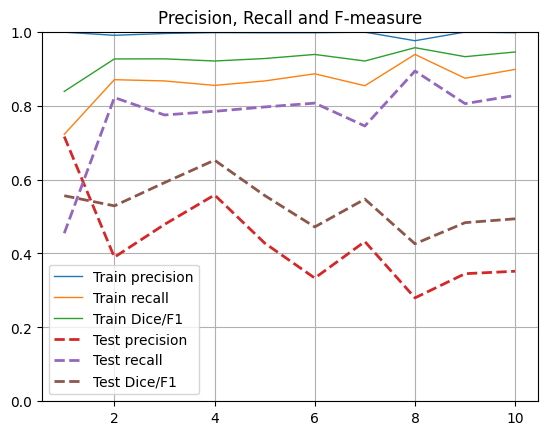

100%|██████████████████████████████████████████| 10/10 [24:10<00:00, 145.07s/it]


pr_c, rec_c, f_meas, pr_nc, rec_nc
[np.float64(0.35178474295086826), np.float64(0.8275591053999224), np.float64(0.49370277816240243), np.float64(0.9612789794107411), np.float64(0.7373523934741354)]
{'train_loss': np.float64(0.05625070631504059), 'train_accuracy': np.float64(95.59382037069115), 'train_nochange_accuracy': np.float64(99.82537841796875), 'train_change_accuracy': np.float64(89.8022232055664), 'test_loss': np.float64(0.7027207016944885), 'test_accuracy': np.float64(75.06066314452336), 'test_nochange_accuracy': np.float64(73.73523712158203), 'test_change_accuracy': np.float64(82.75591278076172)}
Elapsed time for training:
1450.6809284687042
SAVE OK
LOAD OK


100%|█████████████████████████████████████████████| 2/2 [00:19<00:00,  9.78s/it]

{'class_accuracy': [72.12503814697266, 81.9537124633789],
 'dice': np.float64(0.49218660363936756),
 'f_meas': np.float64(0.49218660363936756),
 'kappa': np.float64(0.35062128558340727),
 'net_accuracy': np.float64(73.6561304174675),
 'net_loss': 0.7478318810462952,
 'precision': np.float64(0.35170419396432856),
 'recall': np.float64(0.8195371196937751)}
Elapsed time for testing:
19.622679471969604


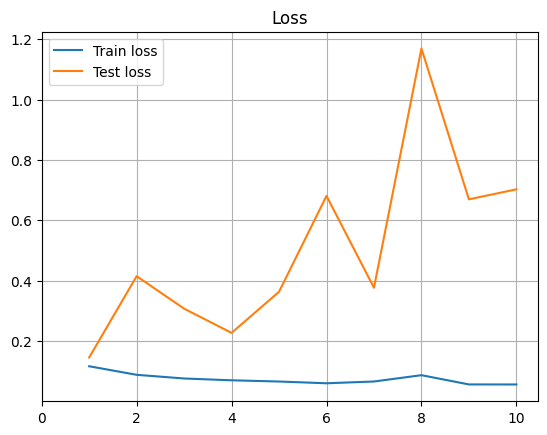

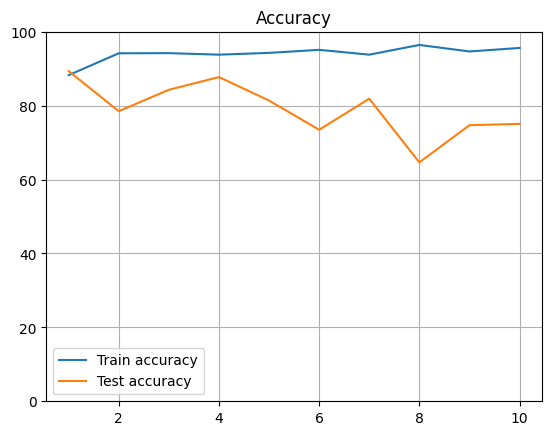

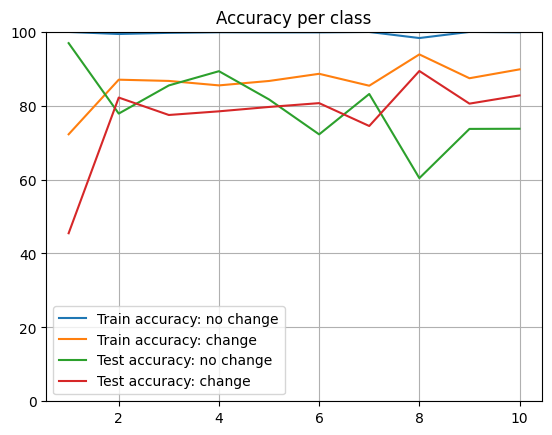

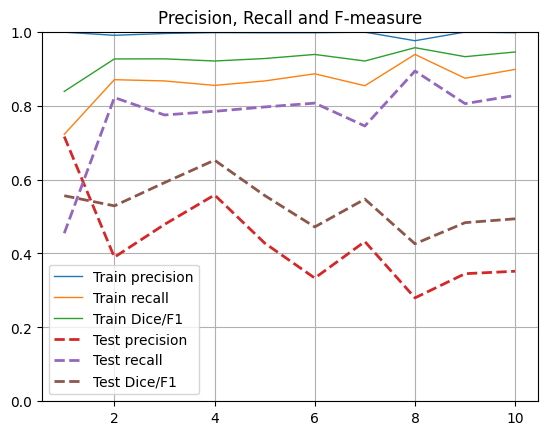

In [6]:
# FresUNet_s reduced network training
netsota, netsota_name = FresUNet_s(2*13, 2), 'FresUNet_s'
loss_fn = nn.NLLLoss(weight=dataset_weights)
netsota = netsota.to(device)
optimizer_netsota= torch.optim.Adam(netsota.parameters(), weight_decay=1e-4)
scheduler_netsota = torch.optim.lr_scheduler.ExponentialLR(optimizer_netsota, 0.95)
print('LOAD OK')
t_start = time.time()
out_dic = train(netsota, netsota_name, loss_fn, optimizer_netsota, scheduler_netsota, feat=False)
t_end = time.time()
print(out_dic)
print('Elapsed time for training:')
print(t_end - t_start)
torch.save(netsota.state_dict(), 'FresUNet_s_crop.pth.tar')
print('SAVE OK')

# Original SoTA network evaluation
netsota.load_state_dict(torch.load('FresUNet_s_crop.pth.tar'))
netsota = netsota.to(device)
print('LOAD OK')
# Evaluate
t_start = time.time()
results = unseen_test_patch_batch(test_dataset, loss_fn, netsota, feat=False)
pprint(results)
t_end = time.time()
print('Elapsed time for testing:')
print(t_end - t_start)

## Proposed Falconet Architecture

In [3]:
# FALCONet network definition
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1)


class BasicBlock_ss(nn.Module):

    def __init__(self, inplanes, planes = None, subsamp=1):
        super(BasicBlock_ss, self).__init__()
        if planes == None:
            planes = inplanes * subsamp
        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.subsamp = subsamp
        self.doit = planes != inplanes
        if self.doit:
            self.couple = nn.Conv2d(inplanes, planes, kernel_size=1)
            self.bnc = nn.BatchNorm2d(planes)

    def forward(self, x):
        if self.doit:
            residual = self.couple(x)
            residual = self.bnc(residual)
        else:
            residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        if self.subsamp > 1:
            out = F.max_pool2d(out, kernel_size=self.subsamp, stride=self.subsamp)
            residual = F.max_pool2d(residual, kernel_size=self.subsamp, stride=self.subsamp)

        out = self.conv2(out)
        out = self.bn2(out)
        
        out += residual
        out = self.relu(out)

        return out
    

    
class BasicBlock_us(nn.Module):

    def __init__(self, inplanes, upsamp=1):
        super(BasicBlock_us, self).__init__()
        planes = int(inplanes / upsamp) # assumes integer result, fix later
        self.conv1 = nn.ConvTranspose2d(inplanes, planes, kernel_size=3, padding=1, stride=upsamp, output_padding=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.upsamp = upsamp
        self.couple = nn.ConvTranspose2d(inplanes, planes, kernel_size=3, padding=1, stride=upsamp, output_padding=1) 
        self.bnc = nn.BatchNorm2d(planes)

    def forward(self, x):
        residual = self.couple(x)
        residual = self.bnc(residual)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        

        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.relu(out)

        return out
    
class AttentionCondenser(nn.Module):
    """Lightweight attention using convolutions instead of full self-attention."""
    def __init__(self, d, reduction=8, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(d, d // reduction, kernel_size=1)
        self.conv2 = nn.Conv2d(d // reduction, d, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout2d(p=dropout)  # Dropout in attention

    def forward(self, x):
        attn = self.conv1(x)
        attn = self.conv2(attn)
        attn = self.dropout(attn)  # Dropout after attention layers
        return x * self.sigmoid(attn)


class ConvAttention(nn.Module):
    def __init__(self, hidden_dim, kernel_size=3, reduction_ratio=8):
        super().__init__()
        reduced_dim = hidden_dim // reduction_ratio

        # Downsample with depthwise conv (local feature extraction)
        self.depthwise_conv = nn.Conv1d(hidden_dim, hidden_dim, kernel_size, padding=kernel_size//2, groups=hidden_dim, bias=False)

        # Pointwise conv (lightweight attention projection)
        self.q_proj = nn.Conv1d(hidden_dim, reduced_dim, 1, bias=False)
        self.k_proj = nn.Conv1d(hidden_dim, reduced_dim, 1, bias=False)
        self.v_proj = nn.Conv1d(hidden_dim, hidden_dim, 1, bias=False)

        # Attention Scoring
        self.score_proj = nn.Conv1d(reduced_dim, hidden_dim, 1, bias=False)

        # Final pointwise conv
        self.out_proj = nn.Conv1d(hidden_dim, hidden_dim, 1, bias=False)

    def forward(self, x):
        """
        x: (batch, seq_len, hidden_dim)
        Output: (batch, seq_len, hidden_dim)
        """
        x = x.transpose(1, 2)  # (batch, hidden_dim, seq_len) for convs

        # Local feature extraction
        x_dw = self.depthwise_conv(x)

        # Query, Key, Value projection
        q = self.q_proj(x_dw)
        k = self.k_proj(x_dw)
        v = self.v_proj(x_dw)

        # Lightweight attention (sigmoid gating)
        attn_scores = self.score_proj(q * k).sigmoid()

        # Apply attention to values
        attn_output = attn_scores * v

        # Final projection
        out = self.out_proj(attn_output)

        # Residual connection
        out = out + x
        return out.transpose(1, 2)  # Back to (batch, seq_len, hidden_dim)


class MultiHeadConvAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads=2, kernel_size=3):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads  # Ensure correct head dim

        assert hidden_dim % num_heads == 0, \
            f"hidden_dim ({hidden_dim}) must be divisible by num_heads ({num_heads})"

        self.heads = nn.ModuleList([
            ConvAttention(self.head_dim, kernel_size) for _ in range(num_heads)
        ])
        self.out_proj = nn.Linear(hidden_dim, hidden_dim, bias=False)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.shape

        #print(f"embed_dim = {embed_dim}, num_heads * head_dim = {self.num_heads * self.head_dim}")  # Debug

        assert embed_dim == self.num_heads * self.head_dim, \
            f"Expected embedding dim {embed_dim} to match {self.num_heads * self.head_dim} (={self.num_heads * self.head_dim})"

        x = x.view(batch_size, seq_len, self.num_heads, self.head_dim)  
        x = x.permute(2, 0, 1, 3)  # (num_heads, batch, seq_len, head_dim)

        x = torch.stack([head(x[i]) for i, head in enumerate(self.heads)], dim=0)

        x = x.permute(1, 2, 0, 3).reshape(batch_size, seq_len, embed_dim)  # Merge heads
        return self.out_proj(x)

class FALCONet(nn.Module):
    """FALCONet segmentation network."""

    def __init__(self, input_nbr, label_nbr, base_depth=8 , encoding_level=3, depth_multiplier= 2, subsampler=2, dropout=0.1, reduction=8, attention=True, num_heads=4):
        """Init FALCONet fields."""
        super(FALCONet, self).__init__()

        self.input_nbr = input_nbr
        
        cur_depth = input_nbr
        
        self.base_depth = base_depth
        self.encoding_level = encoding_level
        self.dropout = dropout
        self.reduction = reduction
        self.attention = attention

        # Encoding stage 1
        self.encres1_1 = BasicBlock_ss(cur_depth, planes = base_depth)
        cur_depth = base_depth
        d1 = base_depth
        self.encres1_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2
        
        # Encoding stage 2
        self.encres2_1 = BasicBlock_ss(cur_depth)
        d2 = cur_depth
        self.encres2_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2

        if self.attention:
            self.token_mixer_2 = MultiHeadConvAttention(cur_depth, num_heads=num_heads)
            # apply attention condensation
            self.attn_condenser_2 = AttentionCondenser(cur_depth, reduction=self.reduction, dropout=self.dropout)
        
        # Encoding stage 3
        self.encres3_1 = BasicBlock_ss(cur_depth)
        d3 = cur_depth
        self.encres3_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2

        if self.attention:
            self.token_mixer_3 = MultiHeadConvAttention(cur_depth, num_heads=num_heads)
            # apply attention condensation
            self.attn_condenser_3 = AttentionCondenser(cur_depth, reduction=self.reduction, dropout=self.dropout)
        
        # Encoding stage 4
        self.encres4_1 = BasicBlock_ss(cur_depth)
        d4 = cur_depth
        self.encres4_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2

        # Decoding stage 4
        self.decres4_1 = BasicBlock_ss(cur_depth)
        self.decres4_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Decoding stage 3
        self.decres3_1 = BasicBlock_ss(cur_depth + d4, planes = cur_depth)
        self.decres3_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Decoding stage 2
        self.decres2_1 = BasicBlock_ss(cur_depth + d3, planes = cur_depth)
        self.decres2_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Decoding stage 1
        self.decres1_1 = BasicBlock_ss(cur_depth + d2, planes = cur_depth)
        self.decres1_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Output
        self.coupling = nn.Conv2d(cur_depth + d1, label_nbr, kernel_size=1)
        self.sm = nn.LogSoftmax(dim=1)
        
    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)
        
        s1_1 = x.size()
        x1 = self.encres1_1(x)
        x = self.encres1_2(x1)
        
        s2_1 = x.size()
        x2 = self.encres2_1(x)
        x = self.encres2_2(x2)

        if self.attention:
            # Flatten spatial dimensions
            B, C, H, W = x.shape
            N = H * W  # Number of tokens
            x = x.view(B, C, N).transpose(1, 2)  # (B, N, C)
            
            # Apply Lightweight Convolutional Multi-Head Attention
            x = self.token_mixer_2(x)  
            
            # Restore spatial shape
            x = x.transpose(1, 2).view(B, C, H, W)  # Restore spatial shape
            x = self.attn_condenser_2(x)
        
        s3_1 = x.size()
        x3 = self.encres3_1(x)
        x = self.encres3_2(x3)

        if self.attention:
            # Flatten spatial dimensions
            B, C, H, W = x.shape
            N = H * W  # Number of tokens
            x = x.view(B, C, N).transpose(1, 2)  # (B, N, C)
            
            # Apply Lightweight Convolutional Multi-Head Attention
            x = self.token_mixer_3(x)  
            
            # Restore spatial shape
            x = x.transpose(1, 2).view(B, C, H, W)  # Restore spatial shape
            x = self.attn_condenser_3(x)


        s4_1 = x.size()
        x4 = self.encres4_1(x)
        x = self.encres4_2(x4)

        feats = x
       
        
        x = self.decres4_1(x)
        x = self.decres4_2(x)
        s4_2 = x.size()
        pad4 = ReplicationPad2d((0, s4_1[3] - s4_2[3], 0, s4_1[2] - s4_2[2]))
        x = pad4(x)
        
        # x = self.decres3_1(x)
        x = self.decres3_1(torch.cat((x, x4), 1))
        x = self.decres3_2(x)
        s3_2 = x.size()
        pad3 = ReplicationPad2d((0, s3_1[3] - s3_2[3], 0, s3_1[2] - s3_2[2]))
        x = pad3(x)
        
        x = self.decres2_1(torch.cat((x, x3), 1))
        x = self.decres2_2(x)
        s2_2 = x.size()
        pad2 = ReplicationPad2d((0, s2_1[3] - s2_2[3], 0, s2_1[2] - s2_2[2]))
        x = pad2(x)
        
        x = self.decres1_1(torch.cat((x, x2), 1))
        x = self.decres1_2(x)
        s1_2 = x.size()
        pad1 = ReplicationPad2d((0, s1_1[3] - s1_2[3], 0, s1_1[2] - s1_2[2]))
        x = pad1(x)
        
        x = self.coupling(torch.cat((x, x1), 1))
        x = self.sm(x)
        
        return x, feats

    def extract_features(self, x1, x2):

        x = torch.cat((x1, x2), 1)
        
        s1_1 = x.size()
        x1 = self.encres1_1(x)
        x = self.encres1_2(x1)
        
        s2_1 = x.size()
        x2 = self.encres2_1(x)
        x = self.encres2_2(x2)

        if self.attention:
            # Flatten spatial dimensions
            B, C, H, W = x.shape
            N = H * W  # Number of tokens
            x = x.view(B, C, N).transpose(1, 2)  # (B, N, C)
            
            # Apply Lightweight Convolutional Multi-Head Attention
            x = self.token_mixer_2(x)  
            
            # Restore spatial shape
            x = x.transpose(1, 2).view(B, C, H, W)  # Restore spatial shape
            x = self.attn_condenser_2(x)
        
        s3_1 = x.size()
        x3 = self.encres3_1(x)
        x = self.encres3_2(x3)

        if self.attention:
            # Flatten spatial dimensions
            B, C, H, W = x.shape
            N = H * W  # Number of tokens
            x = x.view(B, C, N).transpose(1, 2)  # (B, N, C)
            
            # Apply Lightweight Convolutional Multi-Head Attention
            x = self.token_mixer_3(x)  
            
            # Restore spatial shape
            x = x.transpose(1, 2).view(B, C, H, W)  # Restore spatial shape
            x = self.attn_condenser_3(x)


        s4_1 = x.size()
        x4 = self.encres4_1(x)
        x = self.encres4_2(x4)
        
        return x
        
# Example usage
model, model_name = FALCONet(2*13, 2, base_depth=8, encoding_level=4, depth_multiplier=2, subsampler=2, reduction=8, dropout=0.1), 'falconet84228.1'
x = torch.randn(1, 13, 128, 128)
out, feats = model(x, x)
print(summary(model, input_size=(x.shape, x.shape)))
print("Out shape: ", out.shape)  # Expected output: (1, 2, 128, 128)
print("Feats shape: ", feats.shape)  # Expected output: (1, 2, 128, 128)

Layer (type:depth-idx)                   Output Shape              Param #
FALCONet                                 [1, 2, 128, 128]          --
├─BasicBlock_ss: 1-1                     [1, 8, 128, 128]          --
│    └─Conv2d: 2-1                       [1, 8, 128, 128]          216
│    └─BatchNorm2d: 2-2                  [1, 8, 128, 128]          16
│    └─Conv2d: 2-3                       [1, 8, 128, 128]          1,880
│    └─BatchNorm2d: 2-4                  [1, 8, 128, 128]          16
│    └─ReLU: 2-5                         [1, 8, 128, 128]          --
│    └─Conv2d: 2-6                       [1, 8, 128, 128]          584
│    └─BatchNorm2d: 2-7                  [1, 8, 128, 128]          16
│    └─ReLU: 2-8                         [1, 8, 128, 128]          --
├─BasicBlock_ss: 1-2                     [1, 16, 64, 64]           --
│    └─Conv2d: 2-9                       [1, 16, 128, 128]         144
│    └─BatchNorm2d: 2-10                 [1, 16, 128, 128]         32
│    └─Co

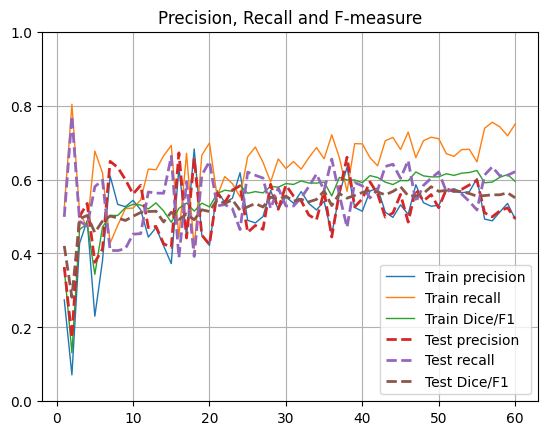

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [6:03:29<00:00, 363.50s/it]
/tmp/ipykernel_1474558/3236305467.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHu

pr_c, rec_c, f_meas, pr_nc, rec_nc
[0.49424453405142943, 0.6212790213316379, 0.5505285100116756, 0.9800309663016632, 0.9669267508005308]
{'train_loss': 0.09146138280630112, 'train_accuracy': 97.84323707715832, 'train_nochange_accuracy': 98.33600616455078, 'train_change_accuracy': 75.00557708740234, 'test_loss': 0.2503712475299835, 'test_accuracy': 94.98344655532455, 'test_nochange_accuracy': 96.69268035888672, 'test_change_accuracy': 62.12790298461914}
Elapsed time for training:
21809.961037158966
SAVE OK
LOAD OK


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.79s/it]

{'class_accuracy': [96.74639892578125, 62.4395751953125],
 'dice': 0.5621667817484124,
 'f_meas': 0.5621667817484124,
 'kappa': 0.5357835611813874,
 'net_accuracy': 94.9733197831274,
 'net_loss': 0.25850117206573486,
 'precision': 0.5112174785763915,
 'recall': 0.624395732884075}
Elapsed time for testing:
57.965301513671875


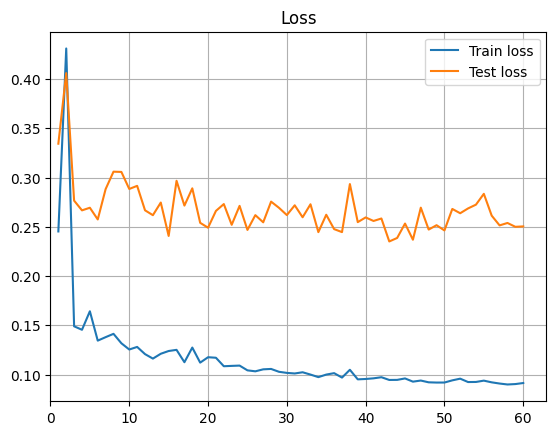

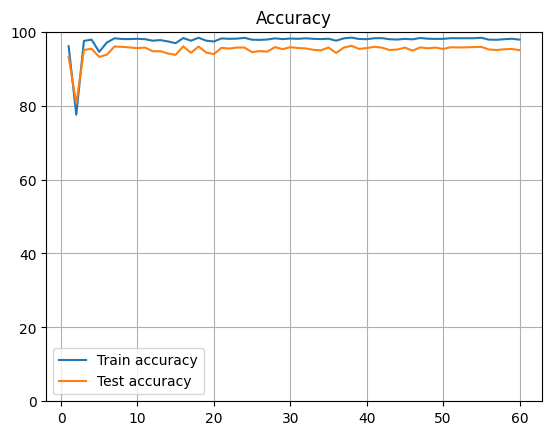

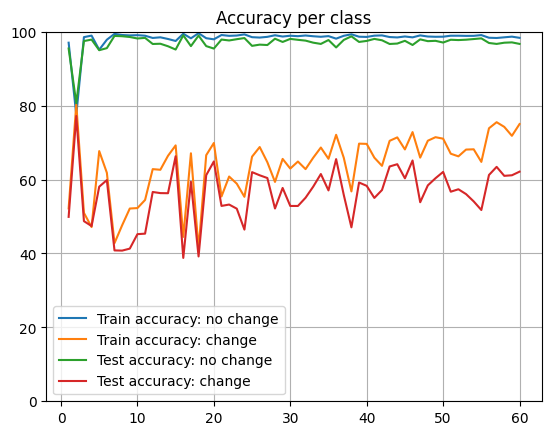

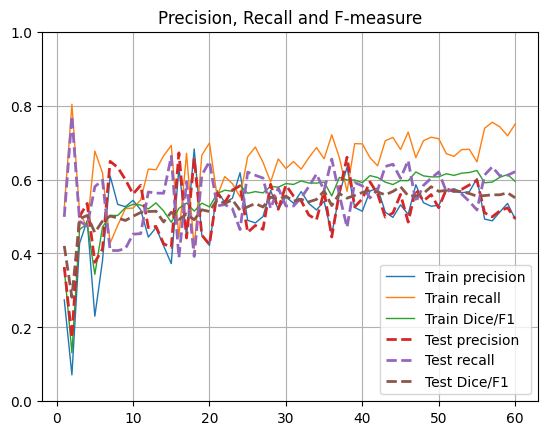

In [23]:
# FALCONet Evaluation - test the gold standard baseline
falconet_retrained, falconet_retrained_name = FALCONet(2*13, 2, base_depth=8, encoding_level=4, depth_multiplier=2, subsampler=2, reduction=8, dropout=0.1), 'falconet_retrained'
falconet_retrained = falconet_retrained.to(device)
optimizer_falconet_retrained = torch.optim.Adam(falconet_retrained.parameters(), weight_decay=1e-4)
scheduler_falconet_retrained = torch.optim.lr_scheduler.ExponentialLR(optimizer_falconet_retrained, 0.95)
print('LOAD OK')
t_start = time.time()
out_dic = train(falconet_retrained, falconet_retrained_name, loss_fn, optimizer_falconet_retrained, scheduler_falconet_retrained, feat=True)
t_end = time.time()
print(out_dic)
print('Elapsed time for training:')
print(t_end - t_start)
torch.save(falconet_retrained.state_dict(), 'falconet_retrained.pth.tar')
print('SAVE OK')

# Original SoTA network evaluation
falconet_retrained.load_state_dict(torch.load('falconet_retrained.pth.tar'))
falconet_retrained = falconet_retrained.to(device)
print('LOAD OK')
# Evaluate
t_start = time.time()
results = unseen_test_patch_batch(test_dataset, loss_fn, falconet_retrained, feat=True)
pprint(results)
t_end = time.time()
print('Elapsed time for testing:')
print(t_end - t_start)

In [9]:
# FALCONet Evaluation - test the gold standard baseline
saved_falconet, saved_falconet_name = FALCONet(2*13, 2, base_depth=8, encoding_level=4, depth_multiplier=2, subsampler=2, reduction=8, dropout=0.1), 'falconet84228.1'
loss_fn = nn.NLLLoss(weight=dataset_weights)
saved_falconet.load_state_dict(torch.load('falconet84228.1.pth.tar', weights_only=True))
saved_falconet = saved_funet.to(device)
print('LOAD OK')
t_start = time.time()
results = unseen_test_patch_batch(test_dataset, loss_fn, saved_funet)
pprint(results)
t_end = time.time()
print('Elapsed time for testing:')
print(t_end - t_start)

FileNotFoundError: [Errno 2] No such file or directory: 'falconet84228.1.pth.tar'

In [4]:
# FALCONetMHA network definition
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1)


class BasicBlock_ss(nn.Module):

    def __init__(self, inplanes, planes = None, subsamp=1):
        super(BasicBlock_ss, self).__init__()
        if planes == None:
            planes = inplanes * subsamp
        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.subsamp = subsamp
        self.doit = planes != inplanes
        if self.doit:
            self.couple = nn.Conv2d(inplanes, planes, kernel_size=1)
            self.bnc = nn.BatchNorm2d(planes)

    def forward(self, x):
        if self.doit:
            residual = self.couple(x)
            residual = self.bnc(residual)
        else:
            residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        if self.subsamp > 1:
            out = F.max_pool2d(out, kernel_size=self.subsamp, stride=self.subsamp)
            residual = F.max_pool2d(residual, kernel_size=self.subsamp, stride=self.subsamp)

        out = self.conv2(out)
        out = self.bn2(out)
        
        out += residual
        out = self.relu(out)

        return out
    

    
class BasicBlock_us(nn.Module):

    def __init__(self, inplanes, upsamp=1):
        super(BasicBlock_us, self).__init__()
        planes = int(inplanes / upsamp) # assumes integer result, fix later
        self.conv1 = nn.ConvTranspose2d(inplanes, planes, kernel_size=3, padding=1, stride=upsamp, output_padding=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.upsamp = upsamp
        self.couple = nn.ConvTranspose2d(inplanes, planes, kernel_size=3, padding=1, stride=upsamp, output_padding=1) 
        self.bnc = nn.BatchNorm2d(planes)

    def forward(self, x):
        residual = self.couple(x)
        residual = self.bnc(residual)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        

        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.relu(out)

        return out
    
class AttentionCondenser(nn.Module):
    """Lightweight attention using convolutions instead of full self-attention."""
    def __init__(self, d, reduction=8, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(d, d // reduction, kernel_size=1)
        self.conv2 = nn.Conv2d(d // reduction, d, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout2d(p=dropout)  # Dropout in attention

    def forward(self, x):
        attn = self.conv1(x)
        attn = self.conv2(attn)
        attn = self.dropout(attn)  # Dropout after attention layers
        return x * self.sigmoid(attn)


class ConvAttention(nn.Module):
    def __init__(self, hidden_dim, kernel_size=3, reduction_ratio=8):
        super().__init__()
        reduced_dim = hidden_dim // reduction_ratio

        # Downsample with depthwise conv (local feature extraction)
        self.depthwise_conv = nn.Conv1d(hidden_dim, hidden_dim, kernel_size, padding=kernel_size//2, groups=hidden_dim, bias=False)

        # Pointwise conv (lightweight attention projection)
        self.q_proj = nn.Conv1d(hidden_dim, reduced_dim, 1, bias=False)
        self.k_proj = nn.Conv1d(hidden_dim, reduced_dim, 1, bias=False)
        self.v_proj = nn.Conv1d(hidden_dim, hidden_dim, 1, bias=False)

        # Attention Scoring
        self.score_proj = nn.Conv1d(reduced_dim, hidden_dim, 1, bias=False)

        # Final pointwise conv
        self.out_proj = nn.Conv1d(hidden_dim, hidden_dim, 1, bias=False)

    def forward(self, x):
        """
        x: (batch, seq_len, hidden_dim)
        Output: (batch, seq_len, hidden_dim)
        """
        x = x.transpose(1, 2)  # (batch, hidden_dim, seq_len) for convs

        # Local feature extraction
        x_dw = self.depthwise_conv(x)

        # Query, Key, Value projection
        q = self.q_proj(x_dw)
        k = self.k_proj(x_dw)
        v = self.v_proj(x_dw)

        # Lightweight attention (sigmoid gating)
        attn_scores = self.score_proj(q * k).sigmoid()

        # Apply attention to values
        attn_output = attn_scores * v

        # Final projection
        out = self.out_proj(attn_output)

        # Residual connection
        out = out + x
        return out.transpose(1, 2)  # Back to (batch, seq_len, hidden_dim)


class MultiHeadConvAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads=2, kernel_size=3):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads  # Ensure correct head dim

        assert hidden_dim % num_heads == 0, \
            f"hidden_dim ({hidden_dim}) must be divisible by num_heads ({num_heads})"

        self.heads = nn.ModuleList([
            ConvAttention(self.head_dim, kernel_size) for _ in range(num_heads)
        ])
        self.out_proj = nn.Linear(hidden_dim, hidden_dim, bias=False)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.shape

        #print(f"embed_dim = {embed_dim}, num_heads * head_dim = {self.num_heads * self.head_dim}")  # Debug

        assert embed_dim == self.num_heads * self.head_dim, \
            f"Expected embedding dim {embed_dim} to match {self.num_heads * self.head_dim} (={self.num_heads * self.head_dim})"

        x = x.view(batch_size, seq_len, self.num_heads, self.head_dim)  
        x = x.permute(2, 0, 1, 3)  # (num_heads, batch, seq_len, head_dim)

        x = torch.stack([head(x[i]) for i, head in enumerate(self.heads)], dim=0)

        x = x.permute(1, 2, 0, 3).reshape(batch_size, seq_len, embed_dim)  # Merge heads
        return self.out_proj(x)

class FALCONetMHA(nn.Module):
    """FALCONetMHA segmentation network."""

    def __init__(self, input_nbr, label_nbr, base_depth=8 , encoding_level=3, depth_multiplier= 2, subsampler=2, dropout=0.1, reduction=8, attention=True, num_heads=4):
        """Init FALCONet fields."""
        super(FALCONetMHA, self).__init__()

        self.input_nbr = input_nbr
        
        cur_depth = input_nbr
        
        self.base_depth = base_depth
        self.encoding_level = encoding_level
        self.dropout = dropout
        self.reduction = reduction
        self.attention = attention

        # Encoding stage 1
        self.encres1_1 = BasicBlock_ss(cur_depth, planes = base_depth)
        cur_depth = base_depth
        d1 = base_depth
        self.encres1_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2
        
        # Encoding stage 2
        self.encres2_1 = BasicBlock_ss(cur_depth)
        d2 = cur_depth
        self.encres2_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2

        if self.attention:
            self.token_mixer_2 = MultiHeadConvAttention(cur_depth, num_heads=num_heads)
            
        # Encoding stage 3
        self.encres3_1 = BasicBlock_ss(cur_depth)
        d3 = cur_depth
        self.encres3_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2

        if self.attention:
            self.token_mixer_3 = MultiHeadConvAttention(cur_depth, num_heads=num_heads)
            
        # Encoding stage 4
        self.encres4_1 = BasicBlock_ss(cur_depth)
        d4 = cur_depth
        self.encres4_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2

        if self.attention:
            self.token_mixer_4 = MultiHeadConvAttention(cur_depth, num_heads=num_heads)

        # Decoding stage 4
        self.decres4_1 = BasicBlock_ss(cur_depth)
        self.decres4_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Decoding stage 3
        self.decres3_1 = BasicBlock_ss(cur_depth + d4, planes = cur_depth)
        self.decres3_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Decoding stage 2
        self.decres2_1 = BasicBlock_ss(cur_depth + d3, planes = cur_depth)
        self.decres2_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Decoding stage 1
        self.decres1_1 = BasicBlock_ss(cur_depth + d2, planes = cur_depth)
        self.decres1_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Output
        self.coupling = nn.Conv2d(cur_depth + d1, label_nbr, kernel_size=1)
        self.sm = nn.LogSoftmax(dim=1)
        
    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)
        
        s1_1 = x.size()
        x1 = self.encres1_1(x)
        x = self.encres1_2(x1)
        
        s2_1 = x.size()
        x2 = self.encres2_1(x)
        x = self.encres2_2(x2)

        if self.attention:
            # Flatten spatial dimensions
            B, C, H, W = x.shape
            N = H * W  # Number of tokens
            x = x.view(B, C, N).transpose(1, 2)  # (B, N, C)
            
            # Apply Lightweight Convolutional Multi-Head Attention
            x = self.token_mixer_2(x)  
            
            # Restore spatial shape
            x = x.transpose(1, 2).view(B, C, H, W)  # Restore spatial shape
        
        s3_1 = x.size()
        x3 = self.encres3_1(x)
        x = self.encres3_2(x3)

        if self.attention:
            # Flatten spatial dimensions
            B, C, H, W = x.shape
            N = H * W  # Number of tokens
            x = x.view(B, C, N).transpose(1, 2)  # (B, N, C)
            
            # Apply Lightweight Convolutional Multi-Head Attention
            x = self.token_mixer_3(x)  
            
            # Restore spatial shape
            x = x.transpose(1, 2).view(B, C, H, W)  # Restore spatial shape


        s4_1 = x.size()
        x4 = self.encres4_1(x)
        x = self.encres4_2(x4)

        feats = x

        if self.attention:
            # Flatten spatial dimensions
            B, C, H, W = x.shape
            N = H * W  # Number of tokens
            x = x.view(B, C, N).transpose(1, 2)  # (B, N, C)
            
            # Apply Lightweight Convolutional Multi-Head Attention
            x = self.token_mixer_4(x)  
            
            # Restore spatial shape
            x = x.transpose(1, 2).view(B, C, H, W)  # Restore spatial shape
       
        
        x = self.decres4_1(x)
        x = self.decres4_2(x)
        s4_2 = x.size()
        pad4 = ReplicationPad2d((0, s4_1[3] - s4_2[3], 0, s4_1[2] - s4_2[2]))
        x = pad4(x)
        
        # x = self.decres3_1(x)
        x = self.decres3_1(torch.cat((x, x4), 1))
        x = self.decres3_2(x)
        s3_2 = x.size()
        pad3 = ReplicationPad2d((0, s3_1[3] - s3_2[3], 0, s3_1[2] - s3_2[2]))
        x = pad3(x)
        
        x = self.decres2_1(torch.cat((x, x3), 1))
        x = self.decres2_2(x)
        s2_2 = x.size()
        pad2 = ReplicationPad2d((0, s2_1[3] - s2_2[3], 0, s2_1[2] - s2_2[2]))
        x = pad2(x)
        
        x = self.decres1_1(torch.cat((x, x2), 1))
        x = self.decres1_2(x)
        s1_2 = x.size()
        pad1 = ReplicationPad2d((0, s1_1[3] - s1_2[3], 0, s1_1[2] - s1_2[2]))
        x = pad1(x)
        
        x = self.coupling(torch.cat((x, x1), 1))
        x = self.sm(x)
        
        return x, feats

    def extract_features(self, x1, x2):

        x = torch.cat((x1, x2), 1)
        
        s1_1 = x.size()
        x1 = self.encres1_1(x)
        x = self.encres1_2(x1)
        
        s2_1 = x.size()
        x2 = self.encres2_1(x)
        x = self.encres2_2(x2)

        if self.attention:
            # Flatten spatial dimensions
            B, C, H, W = x.shape
            N = H * W  # Number of tokens
            x = x.view(B, C, N).transpose(1, 2)  # (B, N, C)
            
            # Apply Lightweight Convolutional Multi-Head Attention
            x = self.token_mixer_2(x)  
            
            # Restore spatial shape
            x = x.transpose(1, 2).view(B, C, H, W)  # Restore spatial shape
            x = self.attn_condenser_2(x)
        
        s3_1 = x.size()
        x3 = self.encres3_1(x)
        x = self.encres3_2(x3)

        if self.attention:
            # Flatten spatial dimensions
            B, C, H, W = x.shape
            N = H * W  # Number of tokens
            x = x.view(B, C, N).transpose(1, 2)  # (B, N, C)
            
            # Apply Lightweight Convolutional Multi-Head Attention
            x = self.token_mixer_3(x)  
            
            # Restore spatial shape
            x = x.transpose(1, 2).view(B, C, H, W)  # Restore spatial shape
            x = self.attn_condenser_3(x)


        s4_1 = x.size()
        x4 = self.encres4_1(x)
        x = self.encres4_2(x4)
        
        return x
        
# Example usage
model, model_name = FALCONetMHA(2*13, 2, base_depth=8, encoding_level=4, depth_multiplier=2, subsampler=2, reduction=8, dropout=0.1), 'falconetmha'
x = torch.randn(1, 13, 128, 128)
out, feats = model(x, x)
print(summary(model, input_size=(x.shape, x.shape)))
print("Out shape: ", out.shape)  # Expected output: (1, 2, 128, 128)
print("Feats shape: ", feats.shape)  # Expected output: (1, 2, 128, 128)

Layer (type:depth-idx)                   Output Shape              Param #
FALCONetMHA                              [1, 2, 128, 128]          --
├─BasicBlock_ss: 1-1                     [1, 8, 128, 128]          --
│    └─Conv2d: 2-1                       [1, 8, 128, 128]          216
│    └─BatchNorm2d: 2-2                  [1, 8, 128, 128]          16
│    └─Conv2d: 2-3                       [1, 8, 128, 128]          1,880
│    └─BatchNorm2d: 2-4                  [1, 8, 128, 128]          16
│    └─ReLU: 2-5                         [1, 8, 128, 128]          --
│    └─Conv2d: 2-6                       [1, 8, 128, 128]          584
│    └─BatchNorm2d: 2-7                  [1, 8, 128, 128]          16
│    └─ReLU: 2-8                         [1, 8, 128, 128]          --
├─BasicBlock_ss: 1-2                     [1, 16, 64, 64]           --
│    └─Conv2d: 2-9                       [1, 16, 128, 128]         144
│    └─BatchNorm2d: 2-10                 [1, 16, 128, 128]         32
│    └─Co

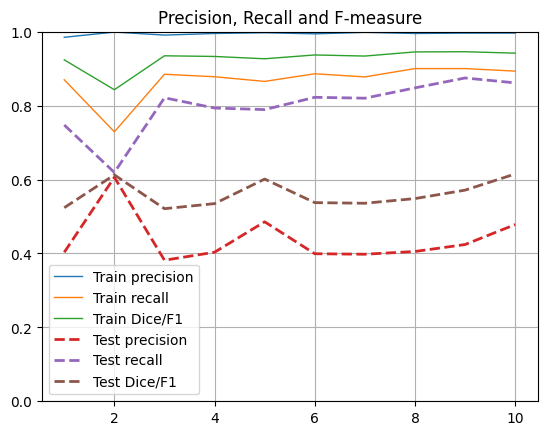

100%|██████████████████████████████████████████| 10/10 [41:25<00:00, 248.55s/it]


pr_c, rec_c, f_meas, pr_nc, rec_nc
[np.float64(0.4781466577241225), np.float64(0.8614799314264382), np.float64(0.6149680115996304), np.float64(0.9723190744590835), np.float64(0.83805606530941)]
{'train_loss': np.float64(0.060438137501478195), 'train_accuracy': np.float64(95.35230454991628), 'train_nochange_accuracy': np.float64(99.75276947021484), 'train_change_accuracy': np.float64(89.32952117919922), 'test_loss': np.float64(0.3481806218624115), 'test_accuracy': np.float64(84.14977770079103), 'test_nochange_accuracy': np.float64(83.80560302734375), 'test_change_accuracy': np.float64(86.14799499511719)}
Elapsed time for training:
2485.5151228904724
SAVE OK
LOAD OK


100%|█████████████████████████████████████████████| 2/2 [00:27<00:00, 13.79s/it]

{'class_accuracy': [82.73096466064453, 85.37095642089844],
 'dice': np.float64(0.6120692016705226),
 'f_meas': np.float64(0.6120692016705226),
 'kappa': np.float64(0.5151648150590166),
 'net_accuracy': np.float64(83.14221772029158),
 'net_loss': 0.3665168881416321,
 'precision': np.float64(0.47704329699209447),
 'recall': np.float64(0.8537095379186017)}
Elapsed time for testing:
27.678977966308594


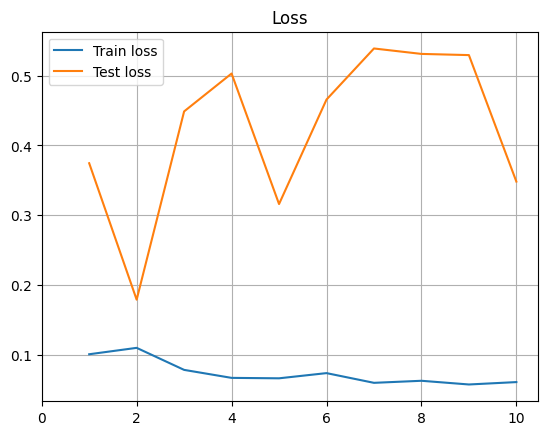

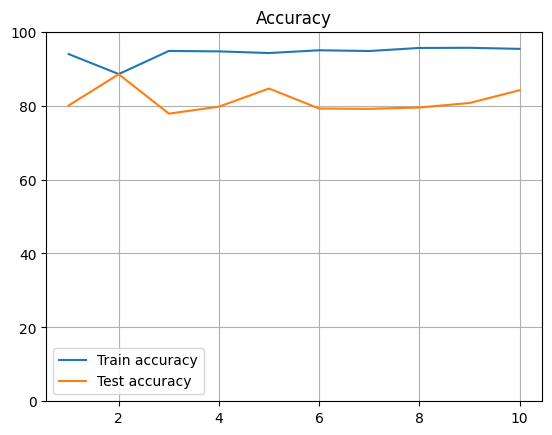

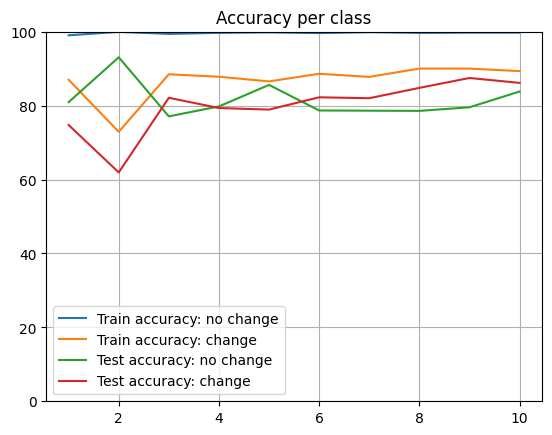

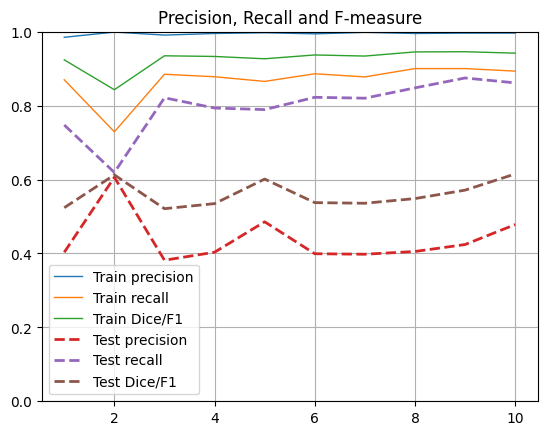

In [8]:
# FALCONetMHA One more Evaluation to balance the PR-REC - the gold standard baseline
falconet_retrained, falconet_retrained_name = FALCONetMHA(2*13, 2, base_depth=8, encoding_level=4, depth_multiplier=2, subsampler=2, reduction=8, dropout=0.1), 'FALCONetMHA_Balance'
falconet_retrained = falconet_retrained.to(device)
loss_fn = nn.NLLLoss(weight=dataset_weights)
optimizer_falconet_retrained = torch.optim.Adam(falconet_retrained.parameters(), weight_decay=1e-4)
scheduler_falconet_retrained = torch.optim.lr_scheduler.ExponentialLR(optimizer_falconet_retrained, 0.95)
print('LOAD OK')
t_start = time.time()
out_dic = train(falconet_retrained, falconet_retrained_name, loss_fn, optimizer_falconet_retrained, scheduler_falconet_retrained, feat=True)
t_end = time.time()
print(out_dic)
print('Elapsed time for training:')
print(t_end - t_start)
torch.save(falconet_retrained.state_dict(), 'FALCONetMHA_Balance_crop.pth.tar')
print('SAVE OK')

# Original SoTA network evaluation
falconet_retrained.load_state_dict(torch.load('FALCONetMHA_Balance_crop.pth.tar'))
falconet_retrained = falconet_retrained.to(device)
print('LOAD OK')
# Evaluate
t_start = time.time()
results = unseen_test_patch_batch(test_dataset, loss_fn, falconet_retrained, feat=True)
pprint(results)
t_end = time.time()
print('Elapsed time for testing:')
print(t_end - t_start)

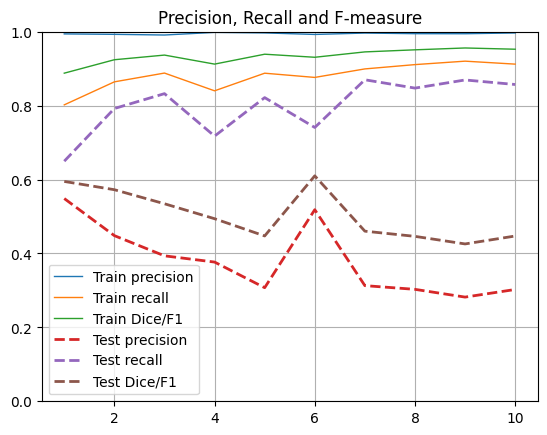

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [36:48<00:00, 220.85s/it]


pr_c, rec_c, f_meas, pr_nc, rec_nc
[np.float64(0.3024682155276725), np.float64(0.8570712801544379), np.float64(0.4471375432293182), np.float64(0.9640185193887216), np.float64(0.6595656474127771)]
{'train_loss': np.float64(0.05124552920460701), 'train_accuracy': np.float64(96.16259599284024), 'train_nochange_accuracy': np.float64(99.77403259277344), 'train_change_accuracy': np.float64(91.2197265625), 'test_loss': np.float64(1.0263042449951172), 'test_accuracy': np.float64(68.85855130203822), 'test_nochange_accuracy': np.float64(65.95655822753906), 'test_change_accuracy': np.float64(85.7071304321289)}
Elapsed time for training:
2208.4843878746033
SAVE OK
LOAD OK


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 11.73s/it]

{'class_accuracy': [65.0689697265625, 85.03541564941406],
 'dice': np.float64(0.45432166124307427),
 'f_meas': np.float64(0.45432166124307427),
 'kappa': np.float64(0.2928621630176712),
 'net_accuracy': np.float64(68.17930453829239),
 'net_loss': 1.0397688150405884,
 'precision': np.float64(0.3099634593811645),
 'recall': np.float64(0.8503541246226897)}
Elapsed time for testing:
23.530755519866943


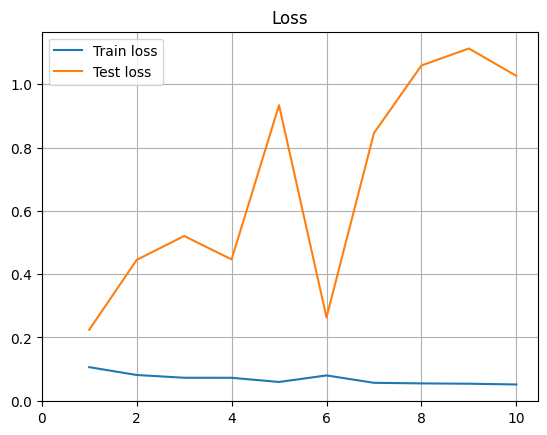

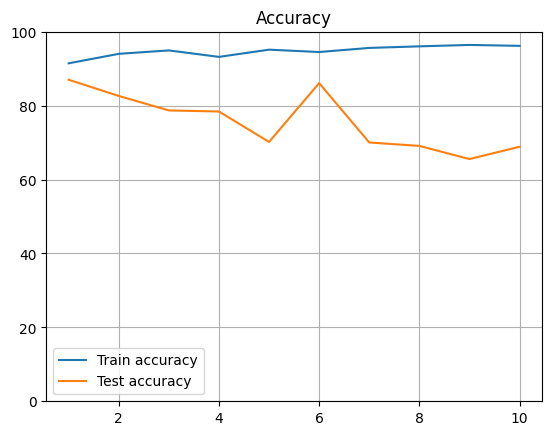

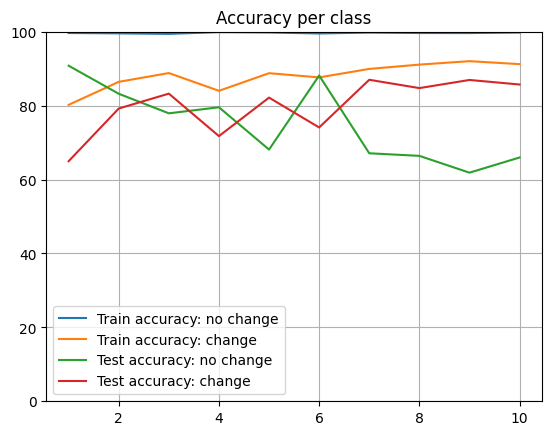

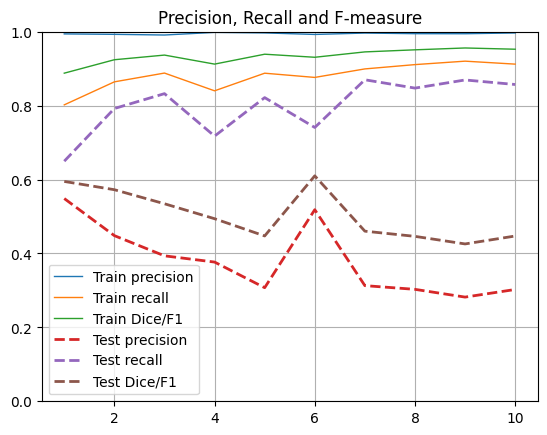

In [5]:
SEED=2342

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# FALCONetMHA One more Evaluation to balance the PR-REC - Crop - weed
falconet_retrained, falconet_retrained_name = FALCONetMHA(2*13, 2, base_depth=8, encoding_level=4, depth_multiplier=2, subsampler=2, reduction=8, dropout=0.1), 'FALCONetMHA_Balance'
falconet_retrained = falconet_retrained.to(device)
loss_fn = nn.NLLLoss(weight=dataset_weights)
optimizer_falconet_retrained = torch.optim.Adam(falconet_retrained.parameters(), weight_decay=1e-4)
scheduler_falconet_retrained = torch.optim.lr_scheduler.ExponentialLR(optimizer_falconet_retrained, 0.95)
print('LOAD OK')
t_start = time.time()
out_dic = train(falconet_retrained, falconet_retrained_name, loss_fn, optimizer_falconet_retrained, scheduler_falconet_retrained, feat=True)
t_end = time.time()
print(out_dic)
print('Elapsed time for training:')
print(t_end - t_start)
torch.save(falconet_retrained.state_dict(), 'FALCONetMHA_crop_attempt2.pth.tar')
print('SAVE OK')

# Original SoTA network evaluation
falconet_retrained.load_state_dict(torch.load('FALCONetMHA_crop_attempt2.pth.tar'))
falconet_retrained = falconet_retrained.to(device)
print('LOAD OK')
# Evaluate
t_start = time.time()
results = unseen_test_patch_batch(test_dataset, loss_fn, falconet_retrained, feat=True)
pprint(results)
t_end = time.time()
print('Elapsed time for testing:')
print(t_end - t_start)

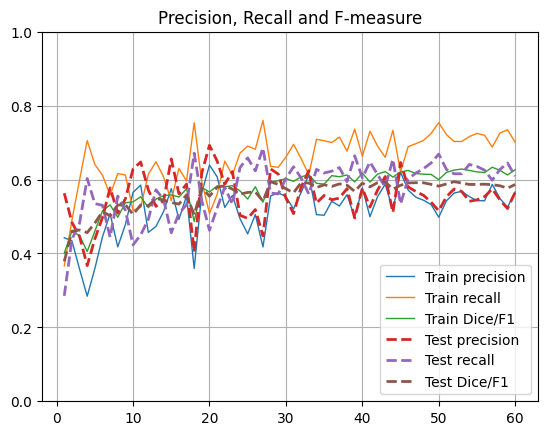

100%|████████████████████████████████████████| 60/60 [2:37:56<00:00, 157.94s/it]


pr_c, rec_c, f_meas, pr_nc, rec_nc
[np.float64(0.5655267412608638), np.float64(0.6090761077968531), np.float64(0.5864941102407961), np.float64(0.9786049654425484), np.float64(0.9744979116839834)]
{'train_loss': np.float64(0.09588048607110977), 'train_accuracy': np.float64(98.07871881241775), 'train_nochange_accuracy': np.float64(98.73663330078125), 'train_change_accuracy': np.float64(70.10176849365234), 'test_loss': np.float64(0.2618979811668396), 'test_accuracy': np.float64(95.5611812591295), 'test_nochange_accuracy': np.float64(97.44979095458984), 'test_change_accuracy': np.float64(60.90761184692383)}
Elapsed time for training:
9476.430222511292
SAVE OK


100%|███████████████████████████████████████████| 10/10 [00:34<00:00,  3.41s/it]

{'class_accuracy': [97.44979095458984, 60.90761184692383],
 'dice': np.float64(0.5864941102407961),
 'f_meas': np.float64(0.5864941102407961),
 'kappa': np.float64(0.563075295125584),
 'net_accuracy': np.float64(95.5611812591295),
 'net_loss': 0.2618979811668396,
 'precision': np.float64(0.5655267412608638),
 'recall': np.float64(0.6090761077968531)}
Elapsed time for testing:
34.06549692153931


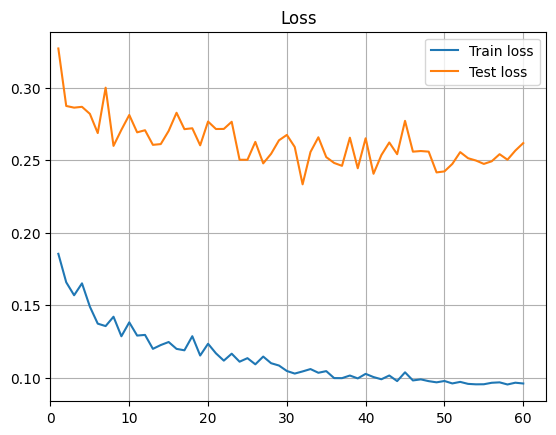

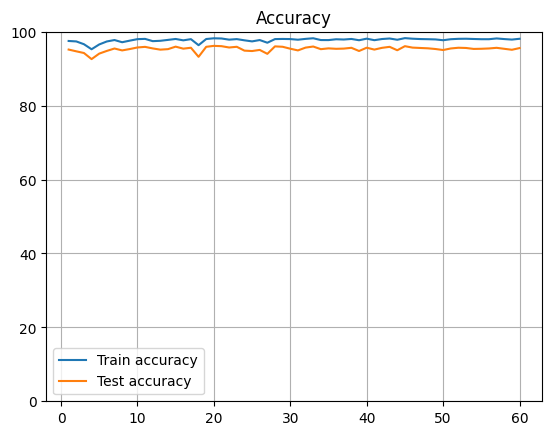

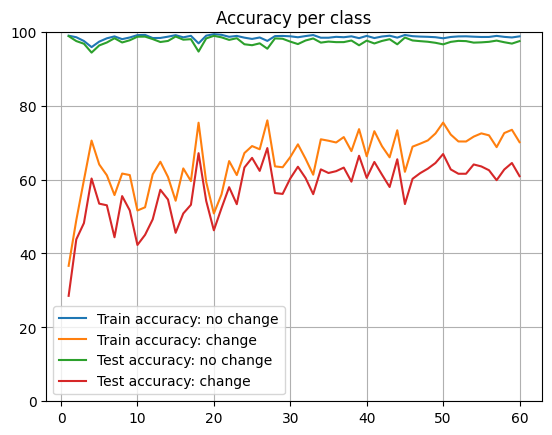

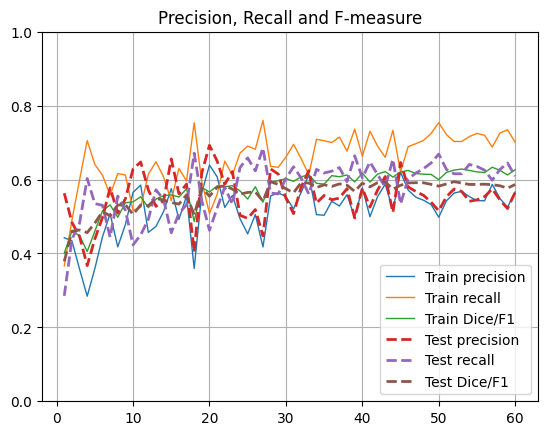

In [7]:
pd_student_model = FALCONetMHA(2*13, 2, base_depth=8, encoding_level=4, depth_multiplier=2, subsampler=2, reduction=8, dropout=0.1)
pd_student_model_name = 'predistilled_falconet_balance'
pd_student_model.load_state_dict(torch.load('./eurostat_student_checkpoints/student_after_chunk1.pt', weights_only=True), strict=False)
pd_student_model = pd_student_model.to(device)
print('LOAD OK')
loss_fn = nn.NLLLoss(weight=dataset_weights)
optimizer = torch.optim.Adam(pd_student_model.parameters(), weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
t_start = time.time()
out_dic = train_batch(pd_student_model, pd_student_model_name, loss_fn, optimizer, scheduler, feat=True)
t_end = time.time()
print(out_dic)
print('Elapsed time for training:')
print(t_end - t_start)
torch.save(pd_student_model.state_dict(), 'predistilled_falconet_balance.pth.tar')
print('SAVE OK')
t_start = time.time()
results = unseen_test_patch_batch(test_dataset, loss_fn, pd_student_model, feat=True)
pprint(results)
t_end = time.time()
print('Elapsed time for testing:')
print(t_end - t_start)

In [8]:
distilled_funet, distilled_funet_name = FALCONetMHA(2*13, 2, base_depth=8, encoding_level=4, depth_multiplier=2, subsampler=2, reduction=8, dropout=0.1), 'Predistilled_FALCONetMHA_Balance'
loss_fn = nn.NLLLoss(weight=dataset_weights)
distilled_funet.load_state_dict(torch.load('./predistilled_falconet_balance.pth.tar', weights_only=True))
distilled_funet = distilled_funet.to(device)
t_start = time.time()
results = unseen_test_patch_batch(test_dataset, loss_fn, distilled_funet, feat=True)
pprint(results)
t_end = time.time()
print('Elapsed time for testing:')
print(t_end - t_start)

100%|███████████████████████████████████████████| 10/10 [00:34<00:00,  3.44s/it]

{'class_accuracy': [97.44979095458984, 60.90761184692383],
 'dice': np.float64(0.5864941102407961),
 'f_meas': np.float64(0.5864941102407961),
 'kappa': np.float64(0.563075295125584),
 'net_accuracy': np.float64(95.5611812591295),
 'net_loss': 0.2618979811668396,
 'precision': np.float64(0.5655267412608638),
 'recall': np.float64(0.6090761077968531)}
Elapsed time for testing:
34.35528373718262


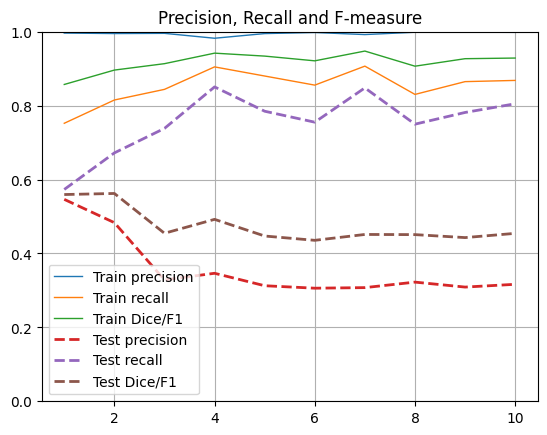

100%|██████████████████████████████████████████| 10/10 [27:03<00:00, 162.37s/it]


pr_c, rec_c, f_meas, pr_nc, rec_nc
[np.float64(0.3164870733805875), np.float64(0.8049344721823734), np.float64(0.45433647386587434), np.float64(0.9496740706487938), np.float64(0.6792244342563115)]
{'train_loss': np.float64(0.05831696093082428), 'train_accuracy': np.float64(94.46971369452669), 'train_nochange_accuracy': np.float64(99.88916015625), 'train_change_accuracy': np.float64(86.81242370605469), 'test_loss': np.float64(1.019784688949585), 'test_accuracy': np.float64(69.88073130400153), 'test_nochange_accuracy': np.float64(67.92244720458984), 'test_change_accuracy': np.float64(80.49344635009766)}
Elapsed time for training:
1623.7168271541595
SAVE OK


100%|█████████████████████████████████████████████| 2/2 [00:24<00:00, 12.00s/it]

{'class_accuracy': [67.92244720458984, 80.49344635009766],
 'dice': np.float64(0.45433647386587434),
 'f_meas': np.float64(0.45433647386587434),
 'kappa': np.float64(0.29716133618577517),
 'net_accuracy': np.float64(69.88073130400153),
 'net_loss': 1.019784688949585,
 'precision': np.float64(0.3164870733805875),
 'recall': np.float64(0.8049344721823734)}
Elapsed time for testing:
24.05192279815674


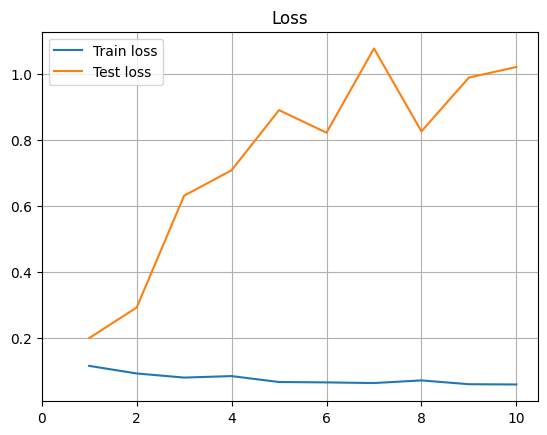

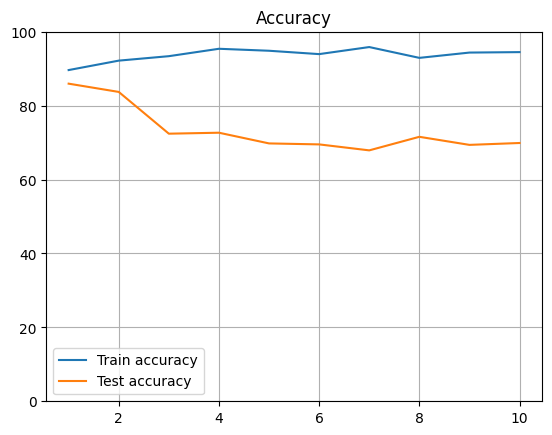

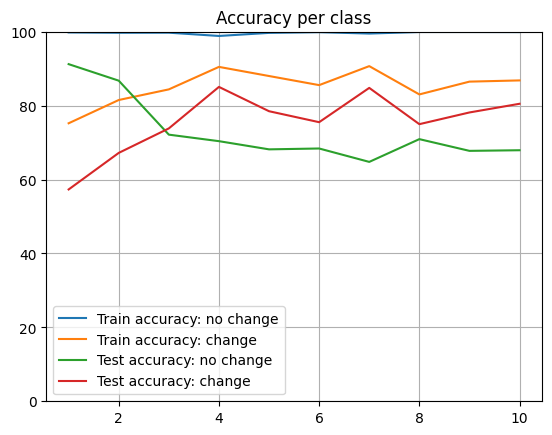

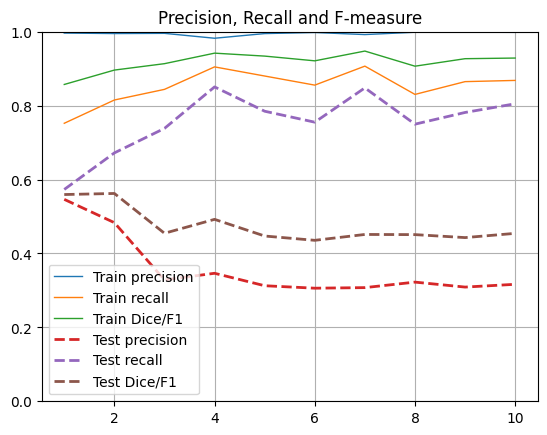

In [9]:
pd_student_model = FALCONetMHA(2*13, 2, base_depth=8, encoding_level=4, depth_multiplier=2, subsampler=2, reduction=8, dropout=0.1)
pd_student_model_name = 'predistilled_falconet_balance'
pd_student_model.load_state_dict(torch.load('./eurostat_student_checkpoints/student_after_chunk1.pt', weights_only=True), strict=False)
pd_student_model = pd_student_model.to(device)
print('LOAD OK')
loss_fn = nn.NLLLoss(weight=dataset_weights)
optimizer = torch.optim.Adam(pd_student_model.parameters(), weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
t_start = time.time()
out_dic = train_batch(pd_student_model, pd_student_model_name, loss_fn, optimizer, scheduler, feat=True)
t_end = time.time()
print(out_dic)
print('Elapsed time for training:')
print(t_end - t_start)
torch.save(pd_student_model.state_dict(), 'predistilled_falconet_balance_crop.pth.tar')
print('SAVE OK')
t_start = time.time()
results = unseen_test_patch_batch(test_dataset, loss_fn, pd_student_model, feat=True)
pprint(results)
t_end = time.time()
print('Elapsed time for testing:')
print(t_end - t_start)

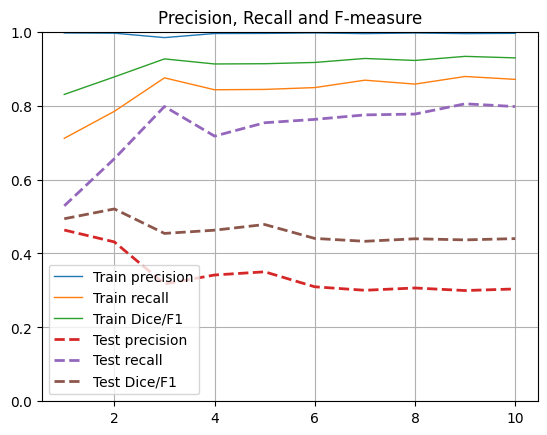

100%|██████████████████████████████████████████| 10/10 [24:59<00:00, 149.96s/it]


pr_c, rec_c, f_meas, pr_nc, rec_nc
[np.float64(0.30393103055673604), np.float64(0.7974282111756799), np.float64(0.44011648304036843), np.float64(0.946630830375192), np.float64(0.6630085956763319)]
{'train_loss': np.float64(0.06519082933664322), 'train_accuracy': np.float64(94.49181752463076), 'train_nochange_accuracy': np.float64(99.72351837158203), 'train_change_accuracy': np.float64(87.09979248046875), 'test_loss': np.float64(1.038913369178772), 'test_accuracy': np.float64(68.39482364552491), 'test_nochange_accuracy': np.float64(66.30085754394531), 'test_change_accuracy': np.float64(79.7428207397461)}
Elapsed time for training:
1499.64346408844
SAVE OK


100%|█████████████████████████████████████████████| 2/2 [00:19<00:00,  9.51s/it]

{'class_accuracy': [66.30085754394531, 79.7428207397461],
 'dice': np.float64(0.44011648304036843),
 'f_meas': np.float64(0.44011648304036843),
 'kappa': np.float64(0.2770292830187743),
 'net_accuracy': np.float64(68.39482364552491),
 'net_loss': 1.038913369178772,
 'precision': np.float64(0.30393103055673604),
 'recall': np.float64(0.7974282111756799)}
Elapsed time for testing:
19.11263608932495


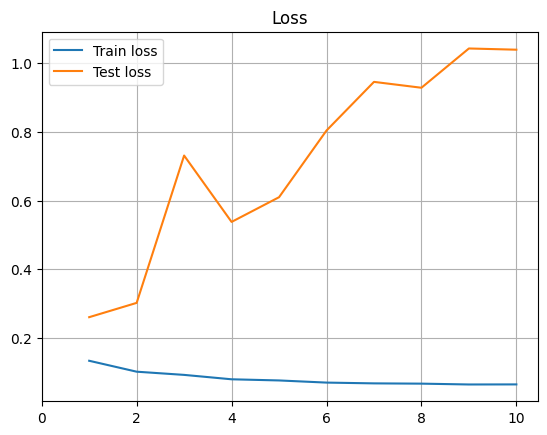

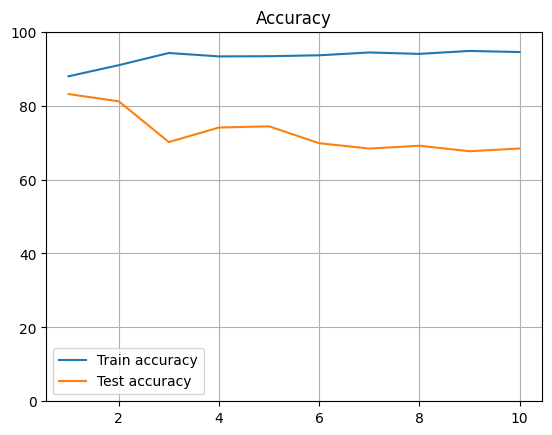

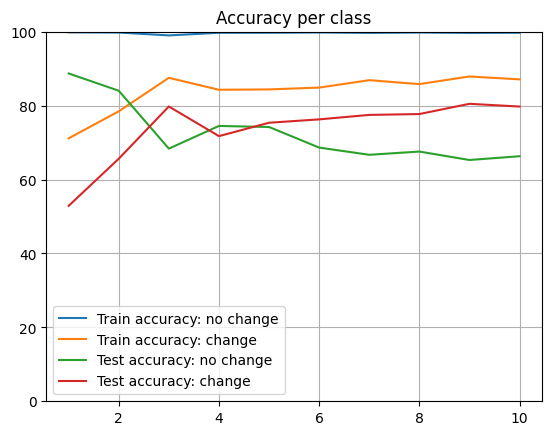

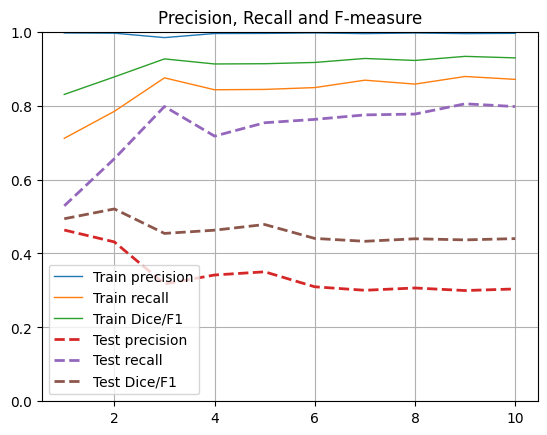

In [10]:
pd_student_model = FALCONetMHA(2*13, 2, base_depth=8, encoding_level=4, depth_multiplier=2, subsampler=2, reduction=8, dropout=0.1)
pd_student_model_name = 'predistilled_falconet_balance'
pd_student_model.load_state_dict(torch.load('./eurostat_student_checkpoints/student_after_chunk1.pt', weights_only=True), strict=False)
pd_student_model = pd_student_model.to(device)
print('LOAD OK')
optimizer = torch.optim.AdamW(pd_student_model.parameters(), lr=5e-4, weight_decay=1e-4)  # Reduced LR from 1e-3 to 5e-4
# Change scheduler from ExponentialLR to CosineAnnealingLR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)  
t_start = time.time()
out_dic = train_batch(pd_student_model, pd_student_model_name, loss_fn, optimizer, scheduler, feat=True)
t_end = time.time()
print(out_dic)
print('Elapsed time for training:')
print(t_end - t_start)
torch.save(pd_student_model.state_dict(), 'predistilled_falconet_balance_mediumloss_crop.pth.tar')
print('SAVE OK')
t_start = time.time()
results = unseen_test_patch_batch(test_dataset, loss_fn, pd_student_model, feat=True)
pprint(results)
t_end = time.time()
print('Elapsed time for testing:')
print(t_end - t_start)

In [12]:
# All SoTA Networks
# The SOTA OSCD network architecture
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1)


class BasicBlock_ss(nn.Module):

    def __init__(self, inplanes, planes = None, subsamp=1):
        super(BasicBlock_ss, self).__init__()
        if planes == None:
            planes = inplanes * subsamp
        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.subsamp = subsamp
        self.doit = planes != inplanes
        if self.doit:
            self.couple = nn.Conv2d(inplanes, planes, kernel_size=1)
            self.bnc = nn.BatchNorm2d(planes)

    def forward(self, x):
        if self.doit:
            residual = self.couple(x)
            residual = self.bnc(residual)
        else:
            residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        if self.subsamp > 1:
            out = F.max_pool2d(out, kernel_size=self.subsamp, stride=self.subsamp)
            residual = F.max_pool2d(residual, kernel_size=self.subsamp, stride=self.subsamp)

        out = self.conv2(out)
        out = self.bn2(out)
        
        out += residual
        out = self.relu(out)

        return out
    

    
class BasicBlock_us(nn.Module):

    def __init__(self, inplanes, upsamp=1):
        super(BasicBlock_us, self).__init__()
        planes = int(inplanes / upsamp) # assumes integer result, fix later
        self.conv1 = nn.ConvTranspose2d(inplanes, planes, kernel_size=3, padding=1, stride=upsamp, output_padding=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.upsamp = upsamp
        self.couple = nn.ConvTranspose2d(inplanes, planes, kernel_size=3, padding=1, stride=upsamp, output_padding=1) 
        self.bnc = nn.BatchNorm2d(planes)

    def forward(self, x):
        residual = self.couple(x)
        residual = self.bnc(residual)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        

        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.relu(out)

        return out
    
    
class FresUNet(nn.Module):
    """FresUNet segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        """Init FresUNet fields."""
        super(FresUNet, self).__init__()

        self.input_nbr = input_nbr
        
        cur_depth = input_nbr
        
        base_depth = 8
        
        # Encoding stage 1
        self.encres1_1 = BasicBlock_ss(cur_depth, planes = base_depth)
        cur_depth = base_depth
        d1 = base_depth
        self.encres1_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2
        
        # Encoding stage 2
        self.encres2_1 = BasicBlock_ss(cur_depth)
        d2 = cur_depth
        self.encres2_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2
        
        # Encoding stage 3
        self.encres3_1 = BasicBlock_ss(cur_depth)
        d3 = cur_depth
        self.encres3_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2
        
        # Encoding stage 4
        self.encres4_1 = BasicBlock_ss(cur_depth)
        d4 = cur_depth
        self.encres4_2 = BasicBlock_ss(cur_depth, subsamp=2)
        cur_depth *= 2
        
        # Decoding stage 4
        self.decres4_1 = BasicBlock_ss(cur_depth)
        self.decres4_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Decoding stage 3
        self.decres3_1 = BasicBlock_ss(cur_depth + d4, planes = cur_depth)
        self.decres3_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Decoding stage 2
        self.decres2_1 = BasicBlock_ss(cur_depth + d3, planes = cur_depth)
        self.decres2_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Decoding stage 1
        self.decres1_1 = BasicBlock_ss(cur_depth + d2, planes = cur_depth)
        self.decres1_2 = BasicBlock_us(cur_depth, upsamp=2)
        cur_depth = int(cur_depth/2)
        
        # Output
        self.coupling = nn.Conv2d(cur_depth + d1, label_nbr, kernel_size=1)
        self.sm = nn.LogSoftmax(dim=1)
        
    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)
        
#         pad5 = ReplicationPad2d((0, x53.size(3) - x5d.size(3), 0, x53.size(2) - x5d.size(2)))
        
        s1_1 = x.size()
        x1 = self.encres1_1(x)
        x = self.encres1_2(x1)
        
        s2_1 = x.size()
        x2 = self.encres2_1(x)
        x = self.encres2_2(x2)
        
        s3_1 = x.size()
        x3 = self.encres3_1(x)
        x = self.encres3_2(x3)
        
        s4_1 = x.size()
        x4 = self.encres4_1(x)
        x = self.encres4_2(x4)
        
        x = self.decres4_1(x)
        x = self.decres4_2(x)
        s4_2 = x.size()
        pad4 = ReplicationPad2d((0, s4_1[3] - s4_2[3], 0, s4_1[2] - s4_2[2]))
        x = pad4(x)
        
        # x = self.decres3_1(x)
        x = self.decres3_1(torch.cat((x, x4), 1))
        x = self.decres3_2(x)
        s3_2 = x.size()
        pad3 = ReplicationPad2d((0, s3_1[3] - s3_2[3], 0, s3_1[2] - s3_2[2]))
        x = pad3(x)
        
        x = self.decres2_1(torch.cat((x, x3), 1))
        x = self.decres2_2(x)
        s2_2 = x.size()
        pad2 = ReplicationPad2d((0, s2_1[3] - s2_2[3], 0, s2_1[2] - s2_2[2]))
        x = pad2(x)
        
        x = self.decres1_1(torch.cat((x, x2), 1))
        x = self.decres1_2(x)
        s1_2 = x.size()
        pad1 = ReplicationPad2d((0, s1_1[3] - s1_2[3], 0, s1_1[2] - s1_2[2]))
        x = pad1(x)
        
        x = self.coupling(torch.cat((x, x1), 1))
        x = self.sm(x)
        
        return x        
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1
        
class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1


class single_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(single_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi


class U_Net(nn.Module):
    def __init__(self,img_ch=26,output_ch=2):
        super(U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)
        self.sm = nn.LogSoftmax(dim=1)


    def forward(self, x1, x2):
        # encoding path
        x = torch.cat((x1, x2), 1)
        
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return self.sm(d1)

class R2U_Net(nn.Module):
    def __init__(self,img_ch=26,output_ch=1,t=2):
        super(R2U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)
        self.sm = nn.LogSoftmax(dim=1)


    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)
        
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return self.sm(d1)




class AttU_Net(nn.Module):
    def __init__(self,img_ch=26,output_ch=1):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)
        self.sm = nn.LogSoftmax(dim=1)


    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)
        
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return self.sm(d1)



class R2AttU_Net(nn.Module):
    def __init__(self,img_ch=26,output_ch=1,t=2):
        super(R2AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)
        self.sm = nn.LogSoftmax(dim=1)


    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)
        
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return self.sm(d1)

In [36]:
saved_funet, saved_funet_name = AttU_Net(2*13, 2), 'AttU_Net'
loss_fn = nn.NLLLoss(weight=dataset_weights)
saved_funet.load_state_dict(torch.load('attunet_25epc.pth.tar', weights_only=True))
saved_funet = saved_funet.to(device)
print('LOAD OK')
t_start = time.time()
results = unseen_test_patch_batch(test_dataset, loss_fn, saved_funet)
pprint(results)
t_end = time.time()
print('Elapsed time for testing AttU_Net:')
print(t_end - t_start)

LOAD OK


100%|███████████████████████████████████████████| 10/10 [01:08<00:00,  6.84s/it]

{'class_accuracy': [97.36516571044922, 63.971534729003906],
 'dice': np.float64(0.6026031242227935),
 'f_meas': np.float64(0.6026031242227935),
 'kappa': np.float64(0.57961596527811),
 'net_accuracy': np.float64(95.63928554719786),
 'net_loss': 0.24098537862300873,
 'precision': np.float64(0.5695608128907321),
 'recall': np.float64(0.639715357971297)}
Elapsed time for testing AttU_Net:
68.5324239730835


In [4]:
saved_funet, saved_funet_name = AttU_Net(2*13, 2), 'AttU_Net'
loss_fn = nn.NLLLoss(weight=dataset_weights)
saved_funet.load_state_dict(torch.load('attunet_25epc.pth.tar', weights_only=True))
saved_funet = saved_funet.to(device)
print('LOAD OK')
save_test_results(saved_funet, test_dataset, saved_funet_name)

LOAD OK


100%|███████████████████████████████████████████| 10/10 [00:31<00:00,  3.12s/it]


In [35]:
saved_funet, saved_funet_name = AttU_Net(2*13, 2), 'AttU_Net'
loss_fn = nn.NLLLoss(weight=dataset_weights)
saved_funet.load_state_dict(torch.load('attunet_60epc.pth.tar', weights_only=True))
saved_funet = saved_funet.to(device)
print('LOAD OK')
t_start = time.time()
results = unseen_test_patch_batch(testaug_dataset, loss_fn, saved_funet, feat=False, ood=True)
pprint(results)
t_end = time.time()
print('Elapsed time for OOD testing AttU_Net:')
print(t_end - t_start)

LOAD OK


100%|███████████████████████████████████████████| 10/10 [01:52<00:00, 11.28s/it]

{'class_accuracy': [97.23336791992188, 18.075523376464844],
 'dice': np.float64(0.21411471228847478),
 'f_meas': np.float64(0.21411471228847478),
 'kappa': np.float64(0.17953661433577503),
 'net_accuracy': np.float64(93.14225506963108),
 'net_loss': 0.918799638748169,
 'precision': np.float64(0.26257442378639),
 'recall': np.float64(0.1807552317431181)}
Elapsed time for OOD testing AttU_Net:
112.92958498001099
